# Performance assessment with LONG WAVE fluxes in ARPEGE-Climat PPE

<a id="top">This code</a> is assessing model performance based on TOA Short Wave fluxes (SW) within the ARPEGE_Climat Perturbed Physics Ensemble. The metric is then used together with emulators (Multi Linear Regression) to constrain the feedback distribution in the ensemble, but also to study a subset of optimal parameter chosen with the total metric $E_{tot}$ and simulated with ARPEGE-Climat 6.3. <br> 

## It is a 6 steps method : 
### [Step 1 - EOF analysis](#EOF)
### [Step 2 - MultiLinReg predictions](#emulator)
### [Step 3 - Projection of observation dataset](#observation)
### [Step 4 - RMSE estimate](#RMSE)
### [Figure histograms](#histograms)
### [Step 5 - Optimisation](#optim)
### [Step 6 - Optimal subset of parameters](#selection)

# Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

# Settings

### Variables

In [2]:
variables = ['rlut']
variable = 'LW'
TITLE = 'Long Wave fluxes'
ylabel = '$E_{LW}$ ($W.m^{-2}.K^{-1}$)'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# <a id="EOF">Step 1 - EOF analysis</a> </li>

For each variable, we consider the climatological mean of the model outputs and we calculate empirical orthogonal functions (EOFs) of the control mean states of the ensemble. In contrast to conventional EOFs, the temporal dimension is replaced by the ensemble itself. This analysis provides a compact description of the spatial and temporal variability of the ensemble variance control climate in term of orthogonal functions, or statistical "modes". The resulting EOFs are spatial patterns, while their principal components ($PCs$) are the expansion coefficients showing the amplitude of the EOF in each ensemble member.

### Functions

In [5]:
def get_3D_LW_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    LW = df['rlut']
    
    return LW

In [6]:
def eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure):
    # Plot the EOF map 

    lat = data['lat'][:]
    lon = data['lon'][:]

    fig = plt.figure(figsize=(10, 10))
    ax=plt.gca()

    eof = eof_nb-1
    data = data[eof]
    ax.set_title(title, fontsize=18, fontweight = 'bold')

    m = Basemap(projection='robin',
            lat_0=0.5*lat[-1], lon_0=-180.0, resolution='c')
    x, y = m(*np.meshgrid(lon,lat))


    cmap = plt.get_cmap('coolwarm',16)  # define the colormap, take the number of discrete colors you want

    m.pcolormesh(x,y,data,shading='gouraud',cmap=cmap)
    #m.colorbar()
    cbar = m.colorbar(location='bottom', spacing = 'uniform', drawedges=True)
    cbar.set_label(' ', size = 16, style = 'italic')

    m.drawcoastlines()
    m.drawmapboundary()
    plt.clim(label_min, label_max)

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

In [7]:
def pc_plot(data, pc_nb, ymin, ymax, title, name_figure):
    #pc = solver.pcs(pcscaling=1)
    #pc = pc*-1

    # Plot the leading PC time series.
    plt.figure(figsize=(10, 5))
    
    pc = pc_nb - 1
    data[:, pc].plot(color='black', linewidth=2)
    ax = plt.gca()
    ax.axhline(0, color='k', alpha=0.5)
    #ax.axvline(x=(8+1), color='red', alpha=0.5)
    #ax.axvline(x=(11+1), color='red', alpha=0.5)
    #ax.axvline(x=(23+1), color='red', alpha=0.5)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Members', size = 16)
    ax.set_ylabel('Normalized Units', size = 16)
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

### Get the data

In [8]:
# Official
path = path_official
filename = '*_CNRM-CM6-1_amip_*.nc'
official_amip = get_3D_LW_xarr(path, filename, variables)

# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_LW_xarr(path, filename, variables)

In [9]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_LW_xarr(path, filename, variables)
    i=i+1  

In [10]:
#amip['official'] = official_amip
amip['p1'] = p1_amip

### Create EOF input matrix

In [11]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

#amip_list[0] = amip['official']
amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    #j=i+1
    amip_list[i+1] = tmp
    i+=1

In [12]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])
matrix

<xarray.DataArray 'rlut' (time: 103, lat: 128, lon: 256)>
dask.array<concatenate, shape=(103, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Dimensions without coordinates: time
Attributes:
    long_name:           TOA Outgoing Longwave Radiation
    units:               W m-2
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       toa_outgoing_longwave_flux
    description:         at the top of the atmosphere (to be compared with sa...
    positive:            up
    history:             none
    cell_measures:       area: areacella

### EOF analysis

In [13]:
# Mean wheigted with cos(lat) : 
lats = matrix['lat'][:]
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat).drop(labels='height').values
W =wgts[np.newaxis,:,np.newaxis]
#W

In [14]:
list_tmp = W[0,:,0]
list_W = []
list_lat = []
list_lon = []
list_mb = []

for j in range(0,256,1) :
    for i in range(0,128,1) :
        list_W.append(list_tmp[i])
        list_lat.append(float(amip['p1']['lat'][i]))
        list_lon.append(float(amip['p1']['lon'][j]))
        #list_mb.append(k)

In [15]:
df = pd.DataFrame(list_W, columns=['W'])#.transpose()
df['lat'] = list_lat
df['lon'] = list_lon
#df['dummy'] = list_dummy
df_W = df.groupby(['lat','lon']).mean().to_xarray()
da_W = df_W.to_array(dim='time')
#df_W = df.drop(dims='variable')
df_W['W']

<xarray.DataArray 'W' (lat: 128, lon: 256)>
array([[0.13679714, 0.13679714, 0.13679714, ..., 0.13679714, 0.13679714,
        0.13679714],
       [0.20723052, 0.20723052, 0.20723052, ..., 0.20723052, 0.20723052,
        0.20723052],
       [0.25940918, 0.25940918, 0.25940918, ..., 0.25940918, 0.25940918,
        0.25940918],
       ...,
       [0.25940918, 0.25940918, 0.25940918, ..., 0.25940918, 0.25940918,
        0.25940918],
       [0.20723052, 0.20723052, 0.20723052, ..., 0.20723052, 0.20723052,
        0.20723052],
       [0.13679714, 0.13679714, 0.13679714, ..., 0.13679714, 0.13679714,
        0.13679714]])
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6

In [16]:
# Compute anomalies by removing the time-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean
anom

<xarray.DataArray 'rlut' (time: 103, lat: 128, lon: 256)>
dask.array<sub, shape=(103, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Dimensions without coordinates: time

In [17]:
mean_df = mean.to_dataframe(name=str(variable)+'mean').drop(labels = 'height', axis=1)
mean_df

anom_df =  anom.to_dataframe(name=str(variables[0])+'mean').drop(labels = 'height', axis=1)
anom_df

rlutmean
time lat        lon                
0    -88.927735 0.00000   -0.255112
                1.40625   -0.255112
                2.81250   -0.255112
                4.21875   -0.255112
                5.62500   -0.255112
...                             ...
102   88.927735 352.96875  1.366318
                354.37500  1.366318
                355.78125  1.366318
                357.18750  1.366318
                358.59375  1.366318

[3375104 rows x 1 columns]

In [18]:
anom_w = (anom*df_W)#.to_array()
anom_w['W']

<xarray.DataArray 'W' (time: 103, lat: 128, lon: 256)>
dask.array<mul, shape=(103, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    height   float64 2.0
Dimensions without coordinates: time

In [20]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom_w['W'], center=False, weights=None)

eof = solver.eofsAsCovariance(neofs=100, pcscaling=0)
pc = solver.pcs(npcs=100, pcscaling=0)

In [21]:
varFrac = solver.varianceFraction(neigs=10)
varFrac

<xarray.DataArray 'variance_fractions' (mode: 10)>
array([0.63593922, 0.09817473, 0.08369549, 0.03274214, 0.02962667,
       0.01788484, 0.01218922, 0.00885598, 0.00556207, 0.00538915])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    long_name:  variance_fractions

### EOF 1 : plotting 

In [23]:
varFrac_list = []
for i in varFrac.values :
    tmp = round(i, 2)
    varFrac_list.append(tmp)
varFrac_list

[0.64, 0.1, 0.08, 0.03, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01]

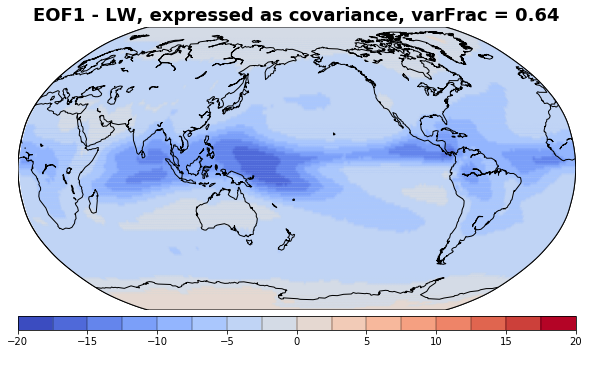

In [24]:
data = eof*(-1)
eof_nb = 1
title = "EOF1 - "+variable+", expressed as covariance, varFrac = "+str(varFrac_list[0])
label_min = -20
label_max = 20
name_figure = "PPE2_EOF1map_"+str(variable)+".png"
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

In [25]:
EOF1_df = eof[0].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF1_df.to_pickle("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap1_"+str(variable)+".npy")

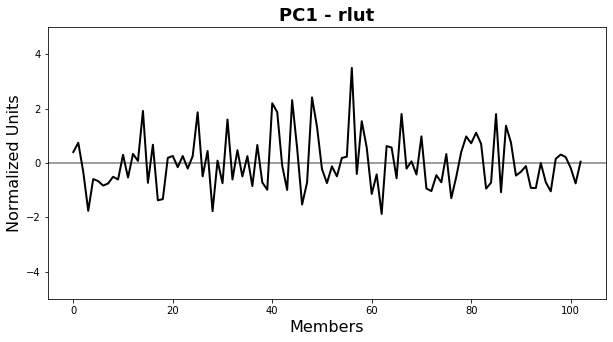

In [26]:
data = pc*(-1)
pc_nb = 1
ymin = -5
ymax = 5
title = "PC1 - "+str(variables[0])
name_figure = "PPE2_EOF1pc_"+str(variable)+".png"
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 2 : plotting 

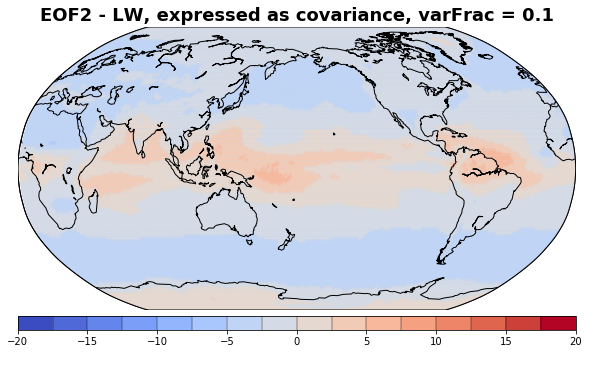

In [27]:
data = eof*(-1)
eof_nb = 2
title = "EOF2 - "+str(variable)+", expressed as covariance, varFrac = "+str(varFrac_list[1])
label_min = -20
label_max = 20
name_figure = 'PPE2_EOF2map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

In [28]:
EOF2_df = eof[1].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF2_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap2_'+str(variable)+'.npy')

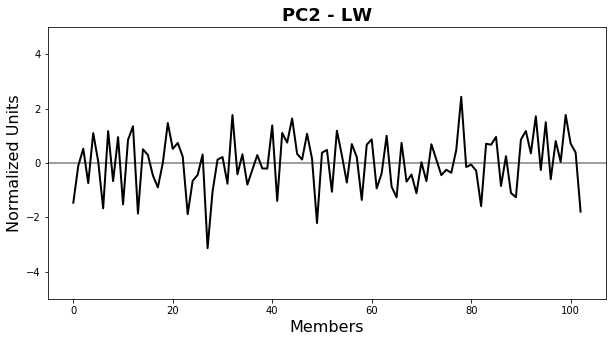

In [29]:
data = pc*(-1)
pc_nb = 2
ymin = -5
ymax = 5
title = 'PC2 - '+str(variable)
name_figure = 'PPE2_EOF2pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 3 : plotting

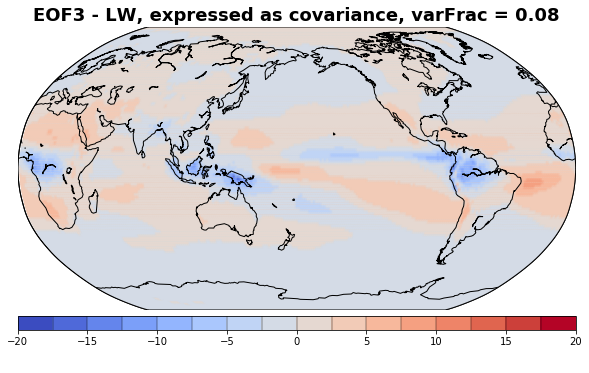

In [30]:
data = eof*(-1)
eof_nb = 3
title = 'EOF3 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[2])
label_min = -20
label_max = 20
name_figure = 'PPE2_EOF3map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

In [31]:
EOF3_df = eof[2].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF3_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap3_'+str(variable)+'.npy')

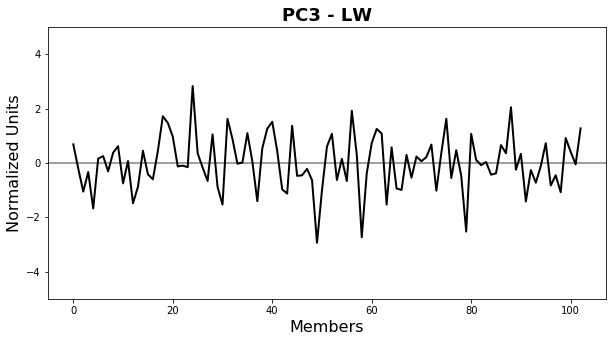

In [32]:
data = pc*(-1)
pc_nb = 3
ymin = -5
ymax = 5
title = 'PC3 - '+str(variable)
name_figure = 'PPE2_EOF3pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 4 : plotting 

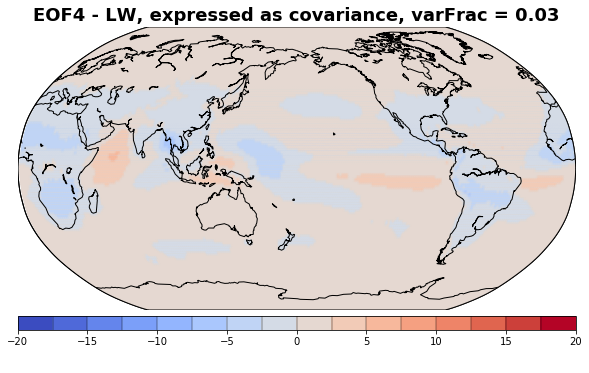

In [33]:
data = eof
eof_nb = 4
title = 'EOF4 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[3])
label_min = -20
label_max = 20
name_figure = 'PPE2_EOF4map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

In [34]:
EOF4_df = eof[3].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF4_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap4_'+str(variable)+'.npy')

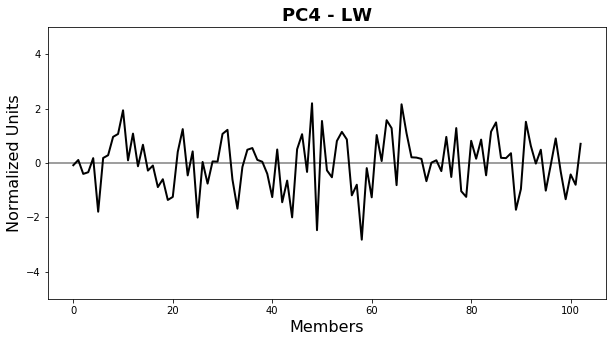

In [35]:
data = pc
pc_nb = 4
ymin = -5
ymax = 5
title = 'PC4 - '+str(variable)
name_figure = 'PPE2_EOF4pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 5 : plotting 

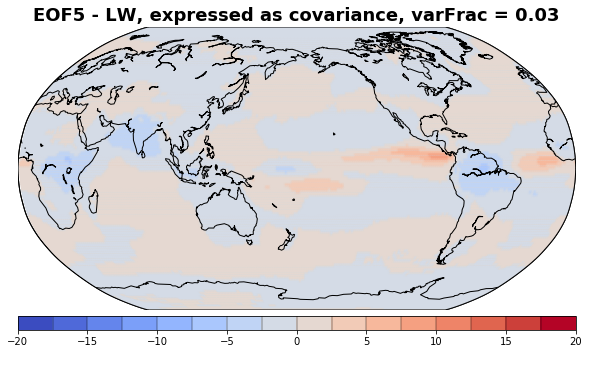

In [36]:
data = eof
eof_nb = 5
title = 'EOF5 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[4])
label_min = -20
label_max = 20
name_figure = 'PPE2_EOF5map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

In [37]:
EOF5_df = eof[4].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF5_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap5_'+str(variable)+'.npy')

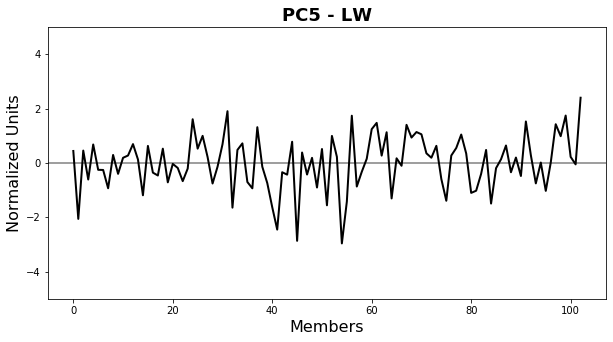

In [38]:
data = pc
pc_nb = 5
ymin = -5
ymax = 5
title = 'PC5 - '+str(variable)
name_figure = 'PPE2_EOF5pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### Save data

In [22]:
#pc1_official = pc[0, 0]
pc1_p1 = pc[0, 0]

pc1 = pc[1:, 0]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF1pc_'+str(variable)+'.npy', pc1_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF1pc_'+str(variable)+'.npy', pc1_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_'+str(variable)+'.npy', pc1)

In [23]:
#pc2_official = pc[0,1]
pc2_p1 = pc[0,1]
pc2 = pc[1:, 1]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF2pc_'+str(variable)+'.npy', pc2_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF2pc_'+str(variable)+'.npy', pc2_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_'+str(variable)+'.npy', pc2)

In [24]:
#pc3_official = pc[0,2]
pc3_p1 = pc[0,2]
pc3 = pc[1:, 2]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF3pc_'+str(variable)+'.npy', pc3_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF3pc_'+str(variable)+'.npy', pc3_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_'+str(variable)+'.npy', pc3)

In [25]:
#pc4_official = pc[0, 3]
pc4_p1 = pc[0, 3]
pc4 = pc[1:, 3]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF4pc_'+str(variable)+'.npy', pc4_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF4pc_'+str(variable)+'.npy', pc4_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_'+str(variable)+'.npy', pc4)

In [26]:
#pc5_official = pc[0, 4]
pc5_p1 = pc[0, 4]
pc5 = pc[1:, 4]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF5pc_'+str(variable)+'.npy', pc5_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF5pc_'+str(variable)+'.npy', pc5_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_'+str(variable)+'.npy', pc5)

In [27]:
## varFrac

# Save the numpy array in a file   
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_varFrac_'+str(variable)+'.npy', varFrac)

In [28]:
# Save the Mean and Anom numpy arrays in a file  

mean_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_'+str(variable)+'_mean.npy')
anom_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_'+str(variable)+'_anom.npy')

### [Back to the top](#top)

# <a id="emulator">Step 2 - MultiLinReg predictions</a> </li>

Use of statistical emulators to predict, based on the perturbed parameter values, ARPEGE-Climat's outputs. The emulators must predict both the climate control mean state (here the global mean tas) and the global net feedback (in another code).  


The emulator is a simple multi linear regression model built and trained to predict the five first $PCs$ of the EOF analysis estimated in [Step 1](#EOF). It is expressed as followed : 
\begin{equation}
    Y = \Sigma_{j=1}^K a_jx_j + R 
    \label{eq_emulator}
\end{equation}

with $Y = PC_i$ the PC of one mode of the EOF analysis ($i=5$), $x_j$ the parameter values, $a_j$ the regression coefficients estimated based on the training of the model, $R$ the intercept and $K=30$ the number of perturbed parameter.

### Functions

In [29]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions_emulation
from Fonctions_emulation import Lasso_tunage
from Fonctions_emulation import Lasso_model
from Fonctions_emulation import plot_model_skill
from Fonctions_emulation import plot_model_skill_lines
from Fonctions_emulation import Lasso_pred
from Fonctions_emulation import MultiLinReg_model
from Fonctions_emulation import MultiLinReg_pred

### EOF 1 - prediction

In [30]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [31]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 3.3703688396122917
Coefficients: 
 [ -81.61348442  -78.5341845     9.25527047    2.97078585  -10.20243313
  -15.86601454  -29.46809254  145.54439288 -119.17555285  536.16049848
 -220.21722468 -181.80938601  -11.96458791  142.21786003  102.12509632
  119.27604838   71.28004824   26.69119085  -61.78855166   11.55195876
  -81.74458369 -103.10923052  217.6077176  -119.34961596  -24.71468231
 -120.84321773   72.29581541  -39.73724707  -84.51257099   -1.87110656]
Score: 
 0.7996790278581019


,y_true,y_eq,members,members_0
0,-637.517010,-223.746072,p311,0
1,284.549365,274.485523,p312,1
2,1516.468332,1466.629967,p314,2
3,511.512731,600.999026,p316,3
4,576.096240,1574.814302,p317,4
...,...,...,...,...
97,-264.651424,280.113961,p465,97
98,-185.080422,221.860903,p467,98
99,154.667106,-484.491295,p469,99
100,649.513277,923.397156,p470,100


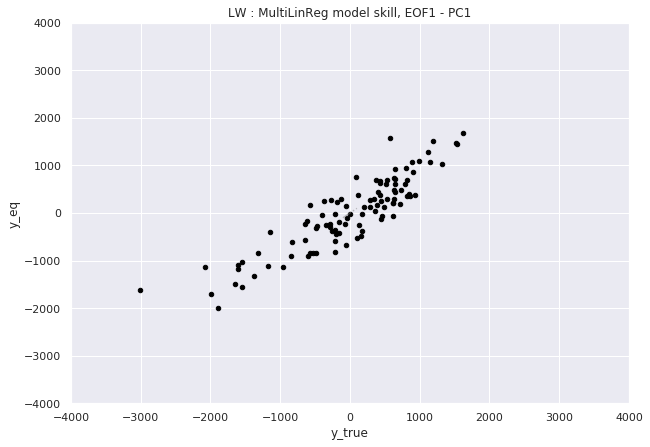

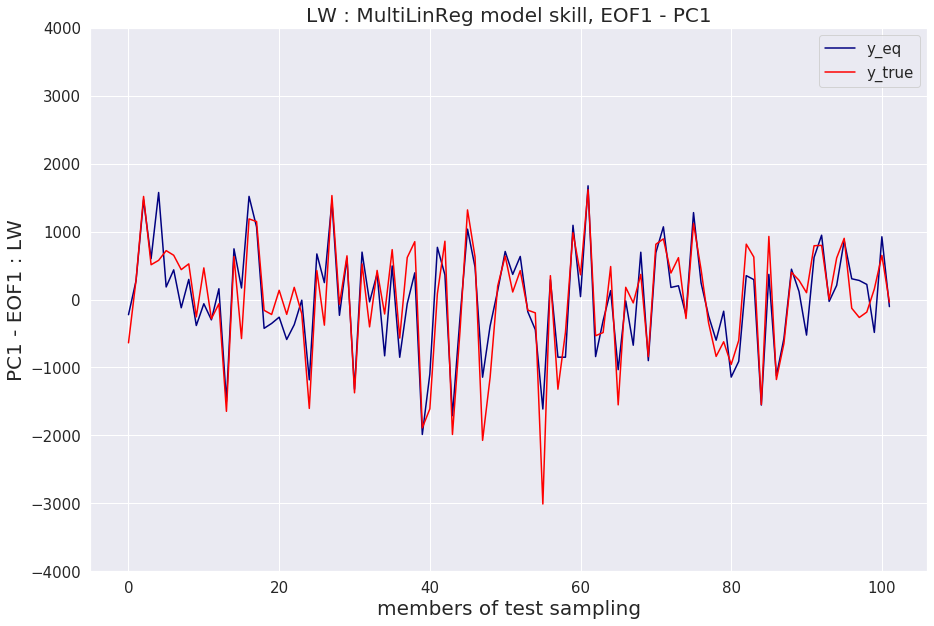

In [35]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF1 - PC1'
xmin = -4000
xmax = 4000
ymin = -4000
ymax = 4000
name = 'MultiLinReg_'+variable+'_skill_pc1.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC1 - EOF1 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [36]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,362.790185,102.0
1,-581.865017,103.0
2,168.155458,104.0
3,1138.281311,105.0
4,-14.179049,106.0
...,...,...
99995,-892.830447,100097.0
99996,-669.877318,100098.0
99997,207.890832,100099.0
99998,-243.144214,100100.0


#### Save data

In [37]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof1_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof1_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 2 - prediction

In [38]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [39]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -4.856136317219913
Coefficients: 
 [ -55.20010217  -65.42596581  -80.615378     -2.89947383   20.59594106
  -15.80072118    6.32799048  -62.31117832   11.85341208  -44.00794187
  -91.37388939 -162.47629868   37.99168161   68.62748174  -45.58712377
  -44.52979911    3.05817439  -95.23277146   21.33014522  -34.45435244
   -4.04433336   54.63749575  -75.2087889   -74.67596744  -22.07183234
  -52.25194189  -27.98968127   23.28882875    0.7221797   -90.50984995]
Score: 
 0.8389828349969258


,y_true,y_eq,members,members_0
0,35.417141,13.107267,p311,0
1,-177.100950,-233.394197,p312,1
2,251.222044,361.313901,p314,2
3,-370.599729,-278.199297,p316,3
4,-20.653389,240.247760,p317,4
...,...,...,...,...
97,-13.093890,99.328957,p465,97
98,-596.391172,-492.338244,p467,98
99,-240.313617,-30.505831,p469,99
100,-129.460877,23.745218,p470,100


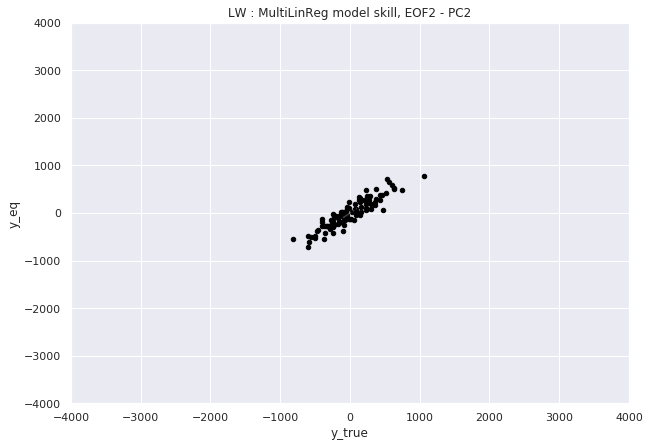

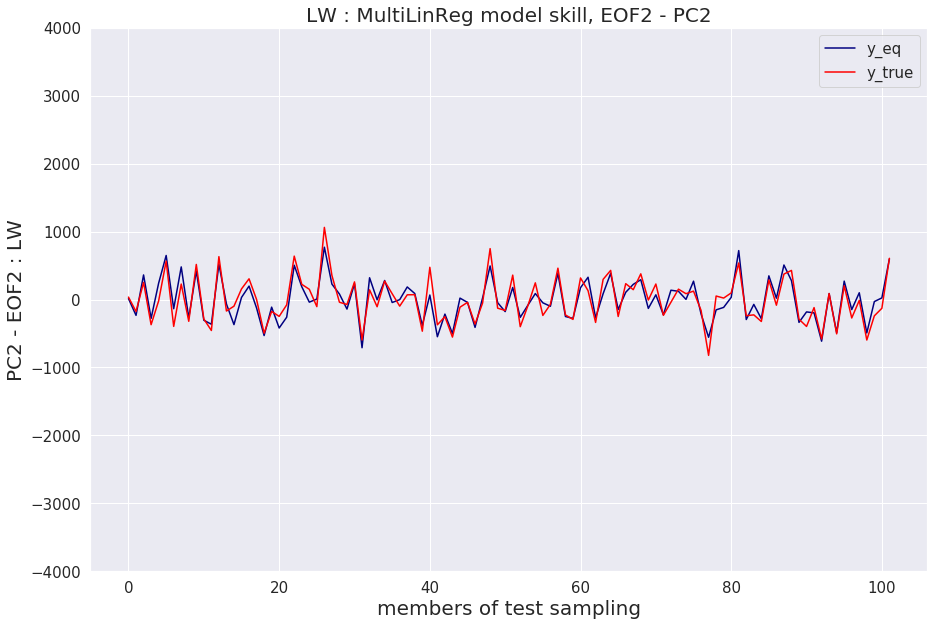

In [40]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF2 - PC2'
xmin = -4000
xmax = 4000
ymin = -4000
ymax = 4000
name = 'MultiLinReg_'+variable+'_skill_pc2.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC2 - EOF2 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [41]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,130.863931,102.0
1,-231.022743,103.0
2,-41.516367,104.0
3,-281.448426,105.0
4,326.265485,106.0
...,...,...
99995,96.502621,100097.0
99996,274.474471,100098.0
99997,-277.170515,100099.0
99998,-161.053132,100100.0


#### Save data

In [42]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof2_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof2_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 3 - prediction

In [43]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [44]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 2.086440950712291
Coefficients: 
 [ 92.28631951 149.84702987  79.66695646   7.07160035 -35.943233
 106.8775512   23.31035254  -3.83499358  57.65641053  68.23400621
 -29.83789754 -33.14368975  64.25222828  53.89974823 -93.74123759
  -2.5438633   22.28680934  29.99394196 -10.08460494 -10.16514132
 -10.36587665 -31.2064297   78.13862301  72.8096549   -9.46923694
 -12.49864483  15.00144336  12.01369254  71.37273398  21.3806364 ]
Score: 
 0.8519553985563667


,y_true,y_eq,members,members_0
0,66.272750,-65.189261,p311,0
1,329.637623,233.869032,p312,1
2,104.951568,172.356679,p314,2
3,522.771615,393.483186,p316,3
4,-49.227536,-167.083307,p317,4
...,...,...,...,...
97,337.538233,139.941612,p465,97
98,-286.591871,-103.438462,p467,98
99,-128.642029,-200.219243,p469,99
100,17.149261,-160.654489,p470,100


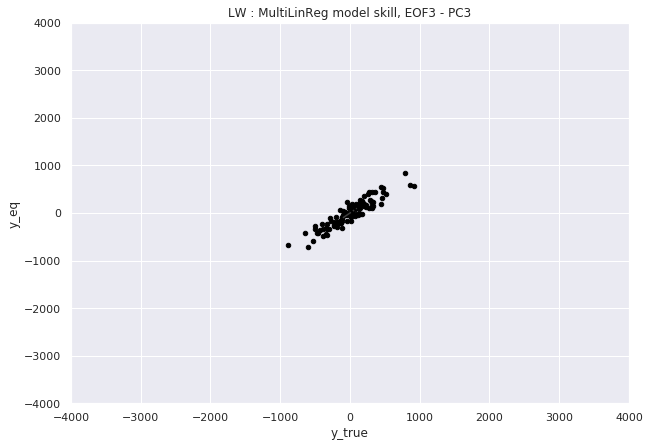

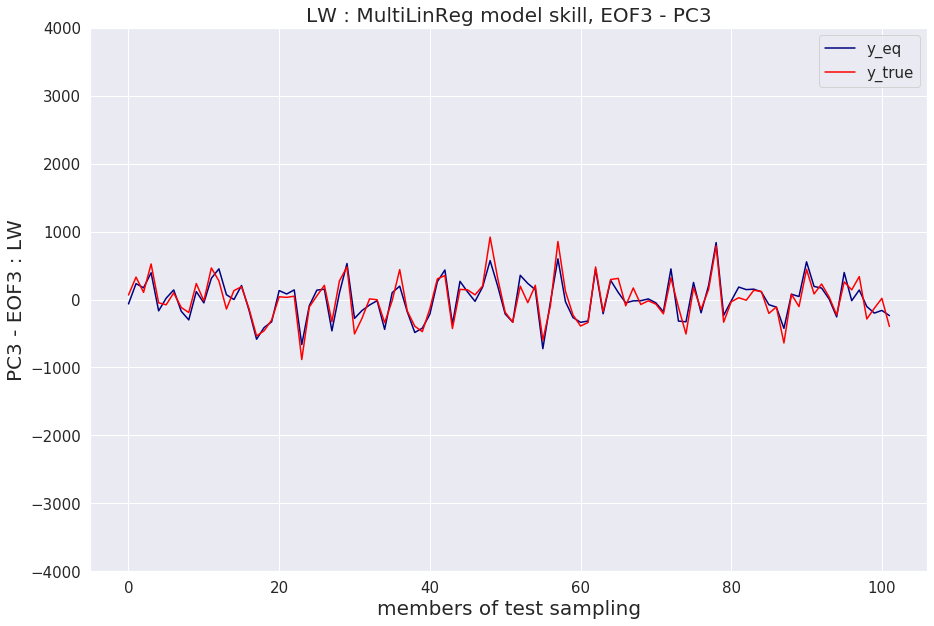

In [45]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF3 - PC3'
xmin = -4000
xmax = 4000
ymin = -4000
ymax = 4000
name = 'MultiLinReg_'+variable+'_skill_pc3.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC3 - EOF3 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [46]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,-300.502493,102.0
1,-395.007065,103.0
2,155.815597,104.0
3,78.671516,105.0
4,-26.920814,106.0
...,...,...
99995,-33.038578,100097.0
99996,59.264065,100098.0
99997,-141.258443,100099.0
99998,-521.999536,100100.0


#### Save data

In [47]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof3_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof3_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 4 - prediction

In [48]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [49]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 0.16331385550905939
Coefficients: 
 [-20.67816415  11.69364415  51.37340339  -0.15419079   4.78398752
 101.98864003 -10.65950435 -20.72263312 -10.49413804 -50.3516071
 -61.94102883 -16.63429075 -20.26682698  11.92373663  36.35424415
   1.54927512  17.28304258  20.75910094  40.35212084 -10.83457452
  -5.9041791  -28.43814658  13.57508875 -34.26036955   4.22016697
  11.30269152   2.03387348 -23.95632201   8.79065073  27.25327568]
Score: 
 0.6470949625736627


,y_true,y_eq,members,members_0
0,20.932770,108.356277,p311,0
1,-79.042613,-44.958529,p312,1
2,-67.072963,-101.510505,p314,2
3,34.260282,3.633343,p316,3
4,-350.834961,-172.319382,p317,4
...,...,...,...,...
97,-61.702979,161.474633,p465,97
98,-261.113501,-29.822094,p467,98
99,-83.051975,-79.069297,p469,99
100,-157.061880,-221.082329,p470,100


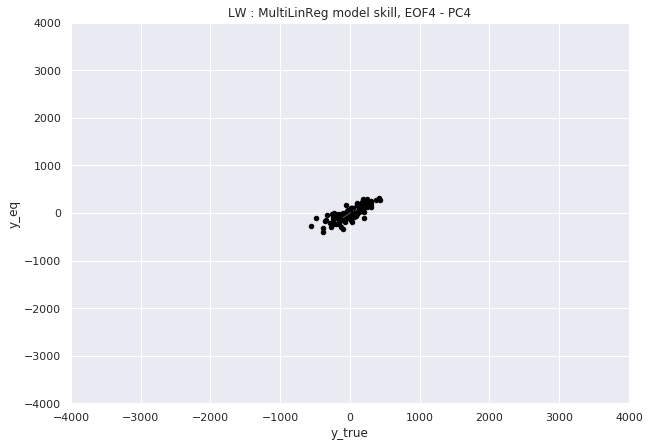

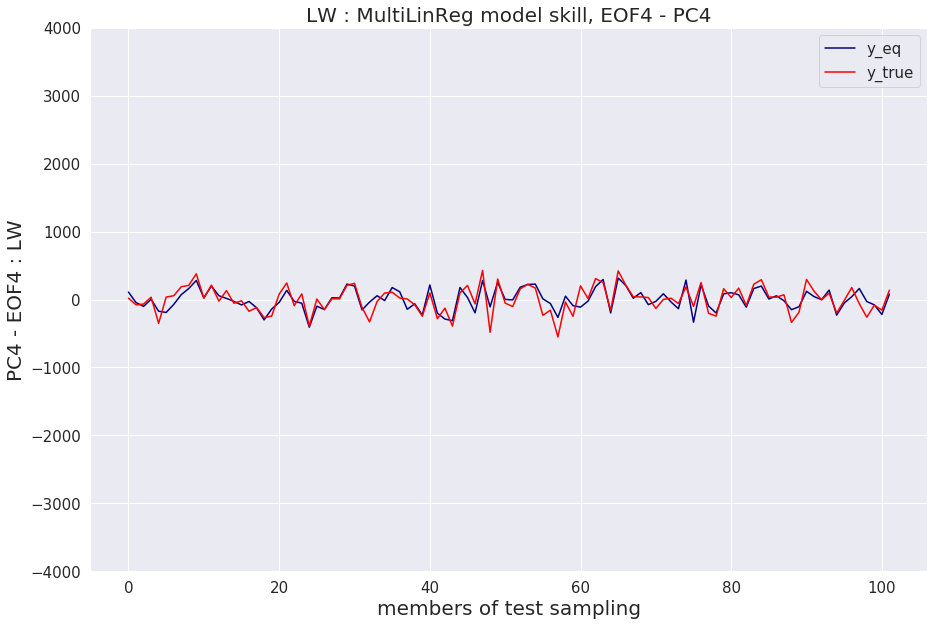

In [50]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF4 - PC4'
xmin = -4000
xmax = 4000
ymin = -4000
ymax = 4000
name = 'MultiLinReg_'+variable+'_skill_pc4.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC4 - EOF4 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [51]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,78.700979,102.0
1,124.774194,103.0
2,-224.798875,104.0
3,-39.053922,105.0
4,270.430897,106.0
...,...,...
99995,114.770452,100097.0
99996,-173.867807,100098.0
99997,-163.544088,100099.0
99998,-428.521498,100100.0


#### Save data

In [52]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof4_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof4_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 5 - prediction

In [53]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [54]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 0.7993310619527141
Coefficients: 
 [ 54.30250318  28.76593646 -11.94107837  19.40736264  -3.59878981
 -22.30670985  -8.82750518 -19.38304635  -2.75338574 -34.77484877
 -20.80022544 -15.2168438  -19.94870634   7.91470578  50.00244628
  23.92470002  -5.88700879  13.67308349  13.6259612   25.08305441
 -35.13494184 -31.61789954 -10.5274811   52.77971624   6.90264271
 -13.82999725   7.87813963   0.70751653   0.84332127   9.42461293]
Score: 
 0.5692649655968951


,y_true,y_eq,members,members_0
0,382.812205,154.514275,p311,0
1,-84.215243,-118.369453,p312,1
2,113.775491,183.297310,p314,2
3,-126.093664,-128.697351,p316,3
4,47.200029,145.472573,p317,4
...,...,...,...,...
97,-182.604472,171.027476,p465,97
98,-323.837645,-314.459025,p467,98
99,-41.203315,-147.765876,p469,99
100,10.078323,-72.475923,p470,100


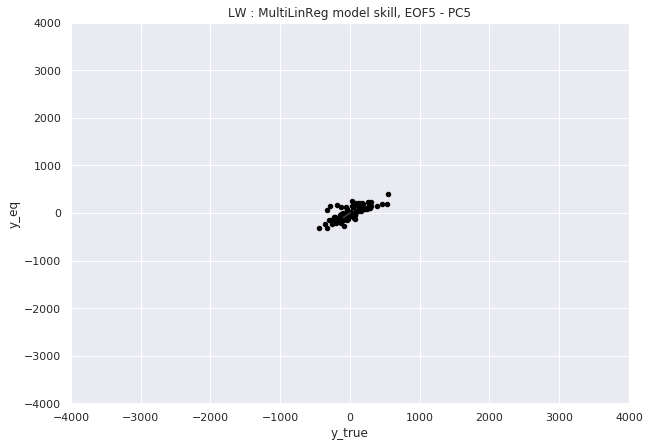

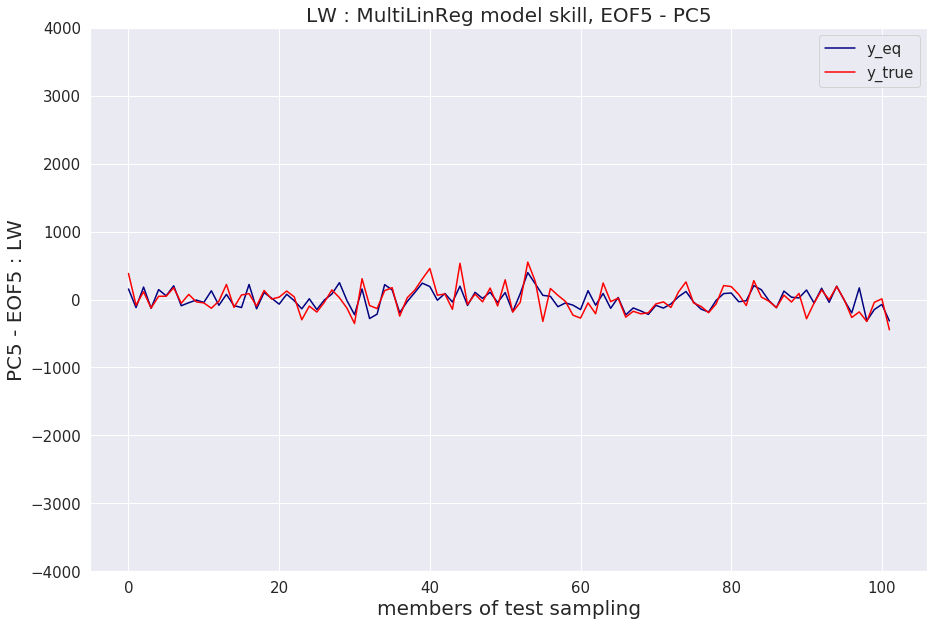

In [55]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF5 - PC5'
xmin = -4000
xmax = 4000
ymin = -4000
ymax = 4000
name = 'MultiLinReg_'+variable+'_skill_pc5.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC5 - EOF5 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [56]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,212.304338,102.0
1,208.305929,103.0
2,-87.411384,104.0
3,256.687018,105.0
4,183.115292,106.0
...,...,...
99995,-229.873553,100097.0
99996,5.861012,100098.0
99997,-17.123278,100099.0
99998,-15.376790,100100.0


#### Save data

In [57]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof5_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof5_'+variable+'.npy', 
        MultiLinReg_prediction)

### [Back to the top](#top)

# <a id="observation">Step 3 - Projection of observation dataset</a> </li>

In this section, we project the observations ($X_{obs}$) onto the EOFs calculated in [Step 1](#EOF). We call $U_{ens}$ the ensemble matrix of EOF amplitudes $w$ such as :  

$U_{ens} = \begin{pmatrix} 
                w_{1,1} & w_{2,1} & w_{3,1} & w_{4,1} & w_{5,1} \\ 
                ... & ... & ... & ... & ... \\
                w_{1,102} & w_{2,102} & w_{3,102} & w_{4,102} & w_{5,102}
           \end{pmatrix}$ 
           
           
<br>
<br>
<br>
The ensemble matrix of spatial patterns is called $v_{ens}$ and is expresses such as : 

$v_{ens} = \begin{pmatrix} 
                eof1(lat,lon)  \\ 
                eof2(lat,lon)  \\ 
                eof3(lat,lon)  \\ 
                eof4(lat,lon)  \\ 
                eof5(lat,lon)  \\ 
           \end{pmatrix}$ 


<br>

The EOF analysis can be expresses as : 
$X_{ens} = U_{ens} \cdot v_{ens}$

And we want the EOF amplitudes of the observations within this basis such as : 

$X_{obs} = U_{obs} \cdot v_{ens}$ 

$U_{obs} = X_{obs} \cdot {v_{ens}}^{-1}$

With : 

$U_{obs} = \begin{pmatrix} 
                o_{1,1} & o_{2,1} & o_{3,1} & o_{4,1} & o_{5,1} \\ 
                ... & ... & ... & ... & ... \\
                o_{1,102} & o_{2,102} & o_{3,102} & o_{4,102} & o_{5,102}
           \end{pmatrix}$ 

### Settings

In [66]:
path_observation = '/data/scratch/globc/peatier/obs_data/CERES/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'

### Functions

In [59]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    #list_ind = []
    #cpt=0
    #for i in df1['year'] : 
    #    if i>1981 :
    #        list_ind.append(cpt)
    #        cpt+=1
    #    else : 
    #        cpt+=1
            
    #df2 = df1.drop(list_ind)
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

### Get the data 

In [60]:
Mean =  pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
Mean

<xarray.DataArray (lat: 128, lon: 256)>
array([[141.47647, 141.47647, 141.47647, ..., 141.47647, 141.47647,
        141.47647],
       [144.50845, 144.50845, 144.50845, ..., 144.50845, 144.50845,
        144.50845],
       [145.13237, 145.13237, 145.13237, ..., 145.86823, 145.13237,
        145.13237],
       ...,
       [189.54474, 189.54474, 189.54474, ..., 189.62494, 189.54474,
        189.54474],
       [189.50299, 189.50299, 189.50299, ..., 189.50299, 189.50299,
        189.50299],
       [187.76024, 187.76024, 187.76024, ..., 187.76024, 187.76024,
        187.76024]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U6 'LWmean'

In [61]:
eof1 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap1_'+variable+'.npy').to_xarray().to_array()
eof2 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap2_'+variable+'.npy').to_xarray().to_array()
eof3 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap3_'+variable+'.npy').to_xarray().to_array()
eof4 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap4_'+variable+'.npy').to_xarray().to_array()
eof5 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap5_'+variable+'.npy').to_xarray().to_array()

eof1 = eof1[0,:,:].rename({'variable':'mode'})
eof2 = eof2[0,:,:].rename({'variable':'mode'})
eof3 = eof3[0,:,:].rename({'variable':'mode'})
eof4 = eof4[0,:,:].rename({'variable':'mode'})
eof5 = eof5[0,:,:].rename({'variable':'mode'})

eofs = [eof1,eof2,eof3,eof4,eof5]

eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')

In [62]:
pc1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_'+variable+'.npy')
pc2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_'+variable+'.npy')
pc3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_'+variable+'.npy')
pc4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_'+variable+'.npy')
pc5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_'+variable+'.npy')

PC_df = pd.DataFrame(pc1)
PC_df['pc1'] = pc1
PC_df['pc2'] = pc2
PC_df['pc3'] = pc3
PC_df['pc4'] = pc4
PC_df['pc5'] = pc5
PC_df = PC_df.drop(labels = 0, axis=1)

#PC_df

In [67]:
# Load data and compute Annual Cycle :
file = xr.open_mfdataset(path_observation+filename,combine='by_coords')
#file
variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path_observation, filename, variables)
df_obs

toa_sw_all_mon  toa_lw_all_mon  toa_net_all_mon
month lat        lon                                                       
1     -88.927735 0.00000        344.953522      189.246185       -38.599289
                 1.40625        344.953522      189.246185       -38.599289
                 2.81250        344.953522      189.246185       -38.599289
                 4.21875        344.992493      189.144440       -38.531315
                 5.62500        345.007721      189.104630       -38.504715
...                                    ...             ...              ...
12     88.927735 352.96875        0.000000      171.476639      -171.476639
                 354.37500        0.000000      171.476639      -171.476639
                 355.78125        0.000000      171.500351      -171.500351
                 357.18750        0.000000      171.560974      -171.560974
                 358.59375        0.000000      171.560974      -171.560974

[393216 rows x 3 columns]

In [68]:
df_obs[variable] =  df_obs['toa_lw_all_mon']
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:          (lat: 128, lon: 256)
Coordinates:
  * lat              (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon              (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
Data variables:
    toa_sw_all_mon   (lat, lon) float32 121.35958 121.35958 ... 103.85324
    toa_lw_all_mon   (lat, lon) float32 142.8201 142.8201 ... 194.14125
    toa_net_all_mon  (lat, lon) float32 -91.40278 -91.40278 ... -126.49493
    LW               (lat, lon) float32 142.8201 142.8201 ... 194.14125

### Compute $U_{obs}$

In [69]:
## MODIFS essais 08/09/2021
X_obs = obs[variable] - Mean
X_obs_bis = (X_obs*df_W)
U_obs_avg = solver.projectField(X_obs_bis['W'], neofs=5, weighted=False, eofscaling=0)#[0,:]
U_obs_avg

<xarray.DataArray 'pseudo_pcs' (mode: 5)>
array([ -58.75523083,  416.47871979, -741.61630427,    5.68958306,
       -238.6481854 ])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4
Attributes:
    long_name:  W_pseudo_pcs

### Save data

In [70]:
#Save the U_obs_avg 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy', U_obs_avg)

# Projection of CFMIP data

In [72]:
variables = ['rlut']

In [73]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month

    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

In [74]:
# Download the amip dataframes and compute the radiative budget  

path = "/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/"
filename = "*_amip_*.nc"
CNRM_amip = load_monthly_clim(path, filename, variables)

path = "/data/scratch/globc/peatier/CMIP6/MRI-ESM2-0/amip/"
filename = "*_amip_*regrid.nc"
MRI_amip = load_monthly_clim(path, filename, variables)

path = "/data/scratch/globc/peatier/CMIP6/CanESM5/amip/"
filename = "standard_*_amip_*regrid.nc"
CAN_amip = load_monthly_clim(path, filename, variables)
CAN_amip

path = "/data/scratch/globc/peatier/CMIP6/MIROC6/"
filename = "*_amip_*regrid.nc"
MIROC_amip = load_monthly_clim(path, filename, variables)
MIROC_amip

path = "/data/scratch/globc/peatier/CMIP6/HadGEM3-GC31-LL/"
filename = "standard_*_amip_*regrid.nc"
HadGEM3_amip = load_monthly_clim(path, filename, variables)
HadGEM3_amip

path = "/data/scratch/globc/peatier/CMIP6/IPSL-CM6A-LR/"
filename = "*_amip_*regrid.nc"
IPSL_amip = load_monthly_clim(path, filename, variables)
IPSL_amip

path = "/data/scratch/globc/peatier/CMIP6/BCC-CSM2-MR/"
filename = "standard_*_amip_*regrid.nc"
BCC_amip = load_monthly_clim(path, filename, variables)
BCC_amip

rlut  height
month lat        lon                          
1     -88.927735 0.00000    185.960541     2.0
                 1.40625    185.925110     2.0
                 2.81250    185.888687     2.0
                 4.21875    185.853851     2.0
                 5.62500    185.800659     2.0
...                                ...     ...
12     88.927735 352.96875  165.538513     2.0
                 354.37500  165.532074     2.0
                 355.78125  165.529419     2.0
                 357.18750  165.519089     2.0
                 358.59375  165.541138     2.0

[393216 rows x 2 columns]

In [75]:
#variables = ['SW']

df_obs = pd.DataFrame()
df_obs['CNRM'] = CNRM_amip[variables[0]]
df_obs['MRI'] = MRI_amip[variables[0]]
df_obs['CAN'] = CAN_amip[variables[0]]
df_obs['MIROC'] = MIROC_amip[variables[0]]
df_obs['HadGEM3'] = HadGEM3_amip[variables[0]]
df_obs['IPSL'] = IPSL_amip[variables[0]]
df_obs['BCC'] = BCC_amip[variables[0]]
#df_obs = df_obs.drop(['rsut', 'height'], axis = 1)
df_obs

CNRM         MRI         CAN       MIROC  \
month lat        lon                                                         
1     -88.927735 0.00000    185.312866  191.050308  194.395706  199.672424   
                 1.40625    185.312866  190.944885  194.394623  199.639511   
                 2.81250    185.312866  190.871658  194.044556  199.592834   
                 4.21875    185.312866  190.784973  194.043549  199.539337   
                 5.62500    185.312866  190.762955  194.042526  199.481033   
...                                ...         ...         ...         ...   
12     88.927735 352.96875  172.606918  169.241440  165.647949  163.121719   
                 354.37500  172.606918  169.257797  165.759399  163.137863   
                 355.78125  172.606918  169.250305  165.759644  163.157043   
                 357.18750  172.606918  169.255676  165.863510  163.157791   
                 358.59375  172.606918  169.260330  165.863800  163.163940   

                               HadGEM3        IPSL         BCC  
month lat        lon                                            
1     -88.927735 0.00000    192.111023  189.196426  185.960541  
                 1.40625    192.087799  189.144714  185.925110  
                 2.81250    192.078903  189.089417  185.888687  
                 4.21875    192.046692  189.021576  185.853851  
                 5.62500    192.015869  188.955856  185.800659  
...                                ...         ...         ...  
12     88.927735 352.96875  168.190277  177.472336  165.538513  
                 354.37500  168.202057  177.507263  165.532074  
                 355.78125  168.214233  177.521210  165.529419  
                 357.18750  168.229095  177.518356  165.519089  
                 358.59375  168.240646  177.534149  165.541138  

[393216 rows x 7 columns]

In [76]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    CNRM     (lat, lon) float32 141.31741 141.31741 ... 190.55353 190.55353
    MRI      (lat, lon) float32 144.62071 144.55673 ... 191.9757 191.97809
    CAN      (lat, lon) float32 145.37804 145.37663 ... 190.26115 190.2614
    MIROC    (lat, lon) float32 145.74411 145.68283 ... 186.1432 186.14372
    HadGEM3  (lat, lon) float32 142.43832 142.40167 ... 191.7751 191.78168
    IPSL     (lat, lon) float32 143.39436 143.30669 ... 196.88176 196.88039
    BCC      (lat, lon) float32 141.79498 141.73112 ... 190.28763 190.28816

## Compute Anomaly

In [77]:
X_obs = {}
X_obs['CNRM'] = obs['CNRM'] - Mean
X_obs['MRI'] = obs['MRI'] - Mean
X_obs['CAN'] = obs['CAN'] - Mean
X_obs['MIROC'] = obs['MIROC'] - Mean
X_obs['HadGEM3'] = obs['HadGEM3'] - Mean
X_obs['IPSL'] = obs['IPSL'] - Mean
X_obs['BCC'] = obs['BCC'] - Mean
X_obs

{'CNRM': <xarray.DataArray (lat: 128, lon: 256)>
 array([[-0.15905762, -0.15905762, -0.15905762, ..., -0.15905762,
         -0.15905762, -0.15905762],
        [-0.9447174 , -0.9447174 , -0.9447174 , ..., -0.9447174 ,
         -0.9447174 , -0.9447174 ],
        [-1.1947937 , -1.1947937 , -1.1947937 , ..., -1.1343689 ,
         -1.1947937 , -1.1947937 ],
        ...,
        [ 2.3907013 ,  2.3907013 ,  2.3907013 , ...,  2.333908  ,
          2.3907013 ,  2.3907013 ],
        [ 2.5970306 ,  2.5970306 ,  2.5970306 , ...,  2.5970306 ,
          2.5970306 ,  2.5970306 ],
        [ 2.7932892 ,  2.7932892 ,  2.7932892 , ...,  2.7932892 ,
          2.7932892 ,  2.7932892 ]], dtype=float32)
 Coordinates:
   * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
   * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
     mode     <U6 'LWmean', 'MRI': <xarray.DataArray (lat: 128, lon: 256)>
 array([[3.1442413, 3.0802612, 3.015442 , ..., 3.3159332, 3.25924

In [78]:
## MODIFS 08/09/2021

X_obs['CNRM'] = (X_obs['CNRM']*df_W)
U_CNRM_avg = solver.projectField(X_obs['CNRM']['W'], neofs=5, weighted=False, eofscaling=0)

X_obs['MRI'] = (X_obs['MRI']*df_W)
U_MRI_avg = solver.projectField(X_obs['MRI']['W'], neofs=5, weighted=False, eofscaling=0)

X_obs['CAN'] = (X_obs['CAN']*df_W)
U_CAN_avg = solver.projectField(X_obs['CAN']['W'], neofs=5, weighted=False, eofscaling=0)

X_obs['MIROC'] = (X_obs['MIROC']*df_W)
U_MIROC_avg = solver.projectField(X_obs['MIROC']['W'], neofs=5, weighted=False, eofscaling=0)

X_obs['HadGEM3'] = (X_obs['HadGEM3']*df_W)
U_HadGEM3_avg = solver.projectField(X_obs['HadGEM3']['W'], neofs=5, weighted=False, eofscaling=0)

X_obs['IPSL'] = (X_obs['IPSL']*df_W)
U_IPSL_avg = solver.projectField(X_obs['IPSL']['W'], neofs=5, weighted=False, eofscaling=0)

X_obs['BCC'] = (X_obs['BCC']*df_W)
U_BCC_avg = solver.projectField(X_obs['BCC']['W'], neofs=5, weighted=False, eofscaling=0)

In [79]:
U_IPSL_avg

<xarray.DataArray 'pseudo_pcs' (mode: 5)>
array([-352.16401486,  331.49272822, -557.3541928 , -360.17448136,
        -68.79895081])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4
Attributes:
    long_name:  W_pseudo_pcs

In [80]:
#Save the U_obs_avg 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_CNRM_'+variable+'.npy', U_CNRM_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_MRI_'+variable+'.npy', U_MRI_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_CAN_'+variable+'.npy', U_CAN_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_MIROC_'+variable+'.npy', U_MIROC_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_HadGEM3_'+variable+'.npy', U_HadGEM3_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_IPSL_'+variable+'.npy', U_IPSL_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_BCC_'+variable+'.npy', U_BCC_avg)

### [Back to the top](#top)

# <a id="RMSE">Step 4 - RMSE estimate</a> </li>

The model error as compared to observations is calculated by comparing the EOF amplitudes $w$ in each member with the projection of the observations $o$ on the model EOF basis through a Root Mean Square Error (RMSE). For a given member of the PPE, the error associated with the variable $s$ is : 

\begin{equation}
    E_{s} = \sqrt{\Sigma_i^N \frac{(w_{is}-o_{is})^2}{N}}
\end{equation}

with $i$ varying from $1$ to $N$, the number of modes considered. In the present study, we truncated the EOF after the 5th mode for each variable : $N=5$.

### Settings

In [16]:
product = 'CERES'
N_error = 128*256

### Functions

In [17]:
def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/N_error)
    return E

In [18]:
def Error(path, filename, U_obs):
    
    U = np.load(path+filename)

    pc1 = U[0]
    pc2 = U[1]
    pc3 = U[2]
    pc4 = U[3]
    pc5 = U[4]

    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/N_error)
    return E

In [19]:
def RMSE_emulator(pc1, pc2, pc3, pc4, pc5, variable) : 
    
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    
    E_pc1 = []
    E_pc2 = []
    E_pc3 = []
    E_pc4 = []
    E_pc5 = []
    E_tmp = []

    for i in pc1:
        tmp = (i-U_obs[0])**2
        E_pc1.append(tmp)
    
    for j in pc2:
        tmp = (j-U_obs[1])**2
        E_pc2.append(tmp)

    for k in pc3:
        tmp = (k-U_obs[2])**2
        E_pc3.append(tmp)
    
    for l in pc4:
        tmp = (l-U_obs[3])**2
        E_pc4.append(tmp)
    
    for m in pc5:
        tmp = (m-U_obs[4])**2
        E_pc5.append(tmp)

    for n in range(0,len(E_pc1),1) :    
        tmp = E_pc1[n]+E_pc2[n]+E_pc3[n]+E_pc4[n]+E_pc5[n]
        E_tmp.append(tmp/N_error)

    
    E = sqrt(E_tmp)
    
    
    return E

### Get the data 

In [20]:
U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')

pc1_obs = U_obs[0]
pc2_obs = U_obs[1]
pc3_obs = U_obs[2]
pc4_obs = U_obs[3]
pc5_obs = U_obs[4]

### p1 default model

In [21]:
pc1_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF1pc_'+variable+'.npy')
pc2_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF2pc_'+variable+'.npy')
pc3_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF3pc_'+variable+'.npy')
pc4_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF4pc_'+variable+'.npy')
pc5_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF5pc_'+variable+'.npy')

p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')

In [22]:
E_p1_tmp = (pc1_p1-pc1_obs)**2 + (pc2_p1-pc2_obs)**2 + (pc3_p1-pc3_obs)**2 + (pc4_p1-pc4_obs)**2 + (pc5_p1-pc5_obs)**2
E_p1 = sqrt(E_p1_tmp/N_error)
        
print(E_p1)

3.4599361083633084


### CMIP6 models

In [23]:
path = '/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/'

filename = 'U_MRI_'+variable+'.npy'
E_MRI = Error(path, filename, U_obs)

filename = 'U_CAN_'+variable+'.npy'
E_CAN = Error(path, filename, U_obs)

filename = 'U_MIROC_'+variable+'.npy'
E_MIROC = Error(path, filename, U_obs)

filename = 'U_HadGEM3_'+variable+'.npy'
E_HadGEM3 = Error(path, filename, U_obs)

filename = 'U_IPSL_'+variable+'.npy'
E_IPSL = Error(path, filename, U_obs)

filename = 'U_BCC_'+variable+'.npy'
E_BCC = Error(path, filename, U_obs)

### PPE

In [24]:
eof1 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap1_'+variable+'.npy').to_xarray().to_array()
eof2 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap2_'+variable+'.npy').to_xarray().to_array()
eof3 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap3_'+variable+'.npy').to_xarray().to_array()
eof4 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap4_'+variable+'.npy').to_xarray().to_array()
eof5 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap5_'+variable+'.npy').to_xarray().to_array()

eof1 = eof1[0,:,:].rename({'variable':'mode'})
eof2 = eof2[0,:,:].rename({'variable':'mode'})
eof3 = eof3[0,:,:].rename({'variable':'mode'})
eof4 = eof4[0,:,:].rename({'variable':'mode'})
eof5 = eof5[0,:,:].rename({'variable':'mode'})

In [25]:
pc1_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_'+variable+'.npy')
pc2_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_'+variable+'.npy')
pc3_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_'+variable+'.npy')
pc4_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_'+variable+'.npy')
pc5_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_'+variable+'.npy')

PC_df_PPE = pd.DataFrame(pc1_PPE)
PC_df_PPE['pc1'] = pc1_PPE
PC_df_PPE['pc2'] = pc2_PPE
PC_df_PPE['pc3'] = pc3_PPE
PC_df_PPE['pc4'] = pc4_PPE
PC_df_PPE['pc5'] = pc5_PPE
PC_df_PPE = PC_df_PPE.drop(labels = 0, axis=1)
PC_df_PPE

,pc1,pc2,pc3,pc4,pc5
0,-637.517010,35.417141,66.272750,20.932770,382.812205
1,284.549365,-177.100950,329.637623,-79.042613,-84.215243
2,1516.468332,251.222044,104.951568,-67.072963,113.775491
3,511.512731,-370.599729,522.771615,34.260282,-126.093664
4,576.096240,-20.653389,-49.227536,-350.834961,47.200029
...,...,...,...,...,...
97,-264.651424,-13.093890,337.538233,-61.702979,-182.604472
98,-185.080422,-596.391172,-286.591871,-261.113501,-323.837645
99,154.667106,-240.313617,-128.642029,-83.051975,-41.203315
100,649.513277,-129.460877,17.149261,-157.061880,10.078323


In [26]:
E_PPE = RMSE_emulator(pc1_PPE, pc2_PPE, pc3_PPE, pc4_PPE, pc5_PPE, variable)
E_PPE

array([ 6.80921836,  7.09349386, 10.11833825,  8.8334118 ,  6.25571523,
        5.9273976 ,  7.8903833 ,  4.75650163,  6.35915282,  6.00986441,
        6.35569514,  8.41671799,  5.85832233, 10.26272751,  6.81467576,
        6.28147781,  7.93888981,  7.21353161,  5.88369242,  4.59571275,
        5.97925784,  5.67881019,  4.99119216,  1.65681045,  9.62085632,
        5.90112814,  6.72806224,  9.31370992,  6.32531688,  8.33260714,
        7.56330943,  7.60384001,  5.2169655 ,  5.70701888,  3.2650938 ,
        6.63793192,  7.65329699,  5.46146314,  6.09569103, 11.79251004,
        9.98269236,  7.63511151,  8.91407884, 12.25421224,  7.5072361 ,
        9.50012191,  7.4840552 , 12.81354089, 11.65519436,  6.95600657,
        6.56313425,  2.54593778,  7.49897901,  6.59272415,  6.13059007,
       16.76962965,  5.56130238, 11.76981271,  6.49548886,  7.65457007,
        3.27174541,  9.70293384,  8.51243491,  4.95804583,  6.62699949,
       11.07171651,  4.11777042,  5.26971495,  4.3974731 ,  6.33

In [27]:
path_observation = '/data/scratch/globc/peatier/obs_data/CERES/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'

def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    #list_ind = []
    #cpt=0
    #for i in df1['year'] : 
    #    if i>1981 :
    #        list_ind.append(cpt)
    #        cpt+=1
    #    else : 
    #        cpt+=1
            
    #df2 = df1.drop(list_ind)
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

# Load data and compute Annual Cycle :
file = xr.open_mfdataset(path_observation+filename,combine='by_coords')
#file
variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path_observation, filename, variables)

df_obs[variable] =  df_obs['toa_lw_all_mon']
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:          (lat: 128, lon: 256)
Coordinates:
  * lat              (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon              (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
Data variables:
    toa_sw_all_mon   (lat, lon) float32 121.35958 121.35958 ... 103.85324
    toa_lw_all_mon   (lat, lon) float32 142.8201 142.8201 ... 194.14125
    toa_net_all_mon  (lat, lon) float32 -91.40278 -91.40278 ... -126.49493
    LW               (lat, lon) float32 142.8201 142.8201 ... 194.14125

In [28]:
ej = {}
ej_list = []
#ej['p1'] = diff_p1

for p in nb_p_list :
    diff_tmp = (amip[p] - obs[variable])**2
    diff = sqrt(diff_tmp.sum(dim=['lat', 'lon'])/(128*256))
    ej[p] = diff
    ej_list.append(float(diff))

In [29]:
df_fig = pd.DataFrame(E_PPE, columns=['E_tas'])
df_fig['RMSE'] = ej_list
df_fig

,E_tas,RMSE
0,6.809218,9.524349
1,7.093494,9.409581
2,10.118338,11.885672
3,8.833412,10.792089
4,6.255715,8.820747
...,...,...
97,6.534499,9.207104
98,6.364555,10.507280
99,5.239393,8.645027
100,6.683621,9.193319


In [31]:
r = np.corrcoef(df_fig['E_tas'], df_fig['RMSE'])
r

array([[1.        , 0.96556208],
       [0.96556208, 1.        ]])

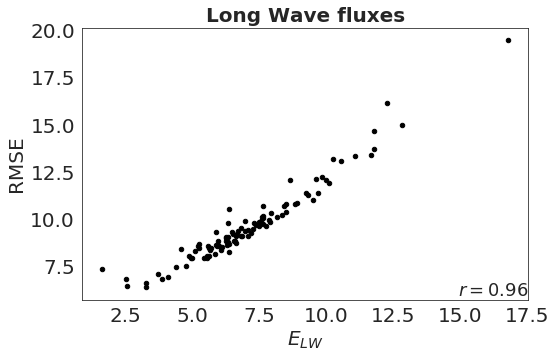

In [33]:
plt.figure(figsize=(8, 5))
    
sns.set_style(style='white')     
ax = plt.gca()
#ax2 = ax.twinx()


df_fig.plot(kind='scatter', x='E_tas', y='RMSE', color = 'black', alpha=1, ax=ax)

#ax.axhline(0, color='k', alpha=0.5)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('$E_{LW}$', size = 20)
ax.set_ylabel('RMSE', size = 20)
ax.set_title('Long Wave fluxes', fontsize=20, 
             fontweight = 'bold')

plt.text(1,0.0,r'$r = 0.96$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)

#plt.xlim([0, 4])
#plt.ylim([0, 4])

# Legend .................

#legend = [ 'Correlation', 'Unresolved fraction']
#ax.get_legend().remove()
#ax.legend(legend, fontsize=25, bbox_to_anchor=(1.65, 0.83)) #bbox_to_anchor=(1.05, 1)
#fig.subplots_adjust(right=0.8)

# Grid .................
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Correl_RMSE_E_"+variable+".png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Multi-Linear Regression predictions

In [102]:
pc1_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof1_'+variable+'.npy')
pc2_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof2_'+variable+'.npy')
pc3_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof3_'+variable+'.npy')
pc4_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof4_'+variable+'.npy')
pc5_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof5_'+variable+'.npy')

PC_df = pd.DataFrame(pc1_pred)
PC_df['pc1'] = pc1_pred
PC_df['pc2'] = pc2_pred
PC_df['pc3'] = pc3_pred
PC_df['pc4'] = pc4_pred
PC_df['pc5'] = pc5_pred
PC_df = PC_df.drop(labels = 0, axis=1)
#PC_df

pc1_pred = PC_df['pc1'].to_xarray().rename({'index':'mode'})
pc2_pred = PC_df['pc2'].to_xarray().rename({'index':'mode'})
pc3_pred = PC_df['pc3'].to_xarray().rename({'index':'mode'})
pc4_pred = PC_df['pc4'].to_xarray().rename({'index':'mode'})
pc5_pred = PC_df['pc5'].to_xarray().rename({'index':'mode'})

In [103]:
pc1_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof1_'+variable+'.npy')
pc2_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof2_'+variable+'.npy')
pc3_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof3_'+variable+'.npy')
pc4_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof4_'+variable+'.npy')
pc5_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof5_'+variable+'.npy')

PC_val_df = pd.DataFrame(pc1_val)
PC_val_df['pc1'] = pc1_val
PC_val_df['pc2'] = pc2_val
PC_val_df['pc3'] = pc3_val
PC_val_df['pc4'] = pc4_val
PC_val_df['pc5'] = pc5_val
PC_val_df = PC_val_df.drop(labels = 0, axis=1)
#PC_df

pc1_val = PC_val_df['pc1'].to_xarray().rename({'index':'mode'})
pc2_val = PC_val_df['pc2'].to_xarray().rename({'index':'mode'})
pc3_val = PC_val_df['pc3'].to_xarray().rename({'index':'mode'})
pc4_val = PC_val_df['pc4'].to_xarray().rename({'index':'mode'})
pc5_val = PC_val_df['pc5'].to_xarray().rename({'index':'mode'})

In [104]:
E_multilinreg_val = RMSE_emulator(pc1_val, pc2_val, pc3_val, pc4_val, pc5_val, variable)
E_multilinreg_val

array([ 4.97982141,  6.77030559, 10.11819739,  8.22800819,  9.89589809,
        4.99014158,  6.82931112,  3.30122644,  5.10427422,  5.44255532,
        5.6277717 ,  7.71471254,  6.77881396,  9.67380748,  7.48797183,
        5.85047879,  9.70203961,  7.01533744,  6.41547621,  4.3646133 ,
        6.83709212,  6.83717255,  5.33932004,  1.50854697,  8.05657369,
        6.74752995,  5.77928248,  8.70944719,  5.7538022 ,  8.68452455,
        7.56956484,  8.48042442,  3.70625293,  5.230715  ,  5.27770261,
        6.53696431,  7.19405717,  3.64587352,  3.901367  , 12.02429429,
        7.20799146,  9.10635993,  8.1071131 , 10.83823161,  6.62756668,
        8.12155522,  7.07284602,  8.42544321,  7.76183292,  6.1352954 ,
        6.38302321,  3.54471681,  8.34695722,  7.14793946,  6.32002151,
        9.10836673,  5.44004409,  8.75519466,  7.00978588,  7.94143122,
        2.79213793, 10.072332  ,  8.82084273,  4.44162373,  5.89337368,
        8.10369105,  4.3398321 ,  5.38185874,  5.85327291,  6.93

In [105]:
E_multilinreg_pred = RMSE_emulator(pc1_pred, pc2_pred, pc3_pred, pc4_pred, pc5_pred, variable)
E_multilinreg_pred

array([4.49658949, 5.59832292, 5.90510663, ..., 5.49766981, 4.46805079,
       6.20186622])

### Get the feedbacks

In [106]:
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
Fdbck_multilinreg_val = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_FdbckN.npy")
Fdbck_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")

Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_MRI = Fdbck_CFMIP[1]
Fdbck_CAN = Fdbck_CFMIP[2]
Fdbck_MIROC = Fdbck_CFMIP[3]
Fdbck_HadGEM3 = Fdbck_CFMIP[4]
Fdbck_IPSL = Fdbck_CFMIP[5]
Fdbck_BCC = Fdbck_CFMIP[6]

In [107]:
E_PPE_df = pd.DataFrame(E_PPE, columns=['E_PPE'])
E_PPE_df['Fdbck'] = Fdbck_PPE

In [108]:
E_multilinreg_val_df = pd.DataFrame(E_multilinreg_val, columns=['E_multilinreg_val'])
E_multilinreg_val_df['Fdbck_val'] = Fdbck_multilinreg_val

E_multilinreg_pred_df = pd.DataFrame(E_multilinreg_pred[0:100000], columns=['E_multilinreg_pred'])
E_multilinreg_pred_df['Fdbck_pred'] = Fdbck_multilinreg_pred
#E_multilinreg_pred_df

### Plotting

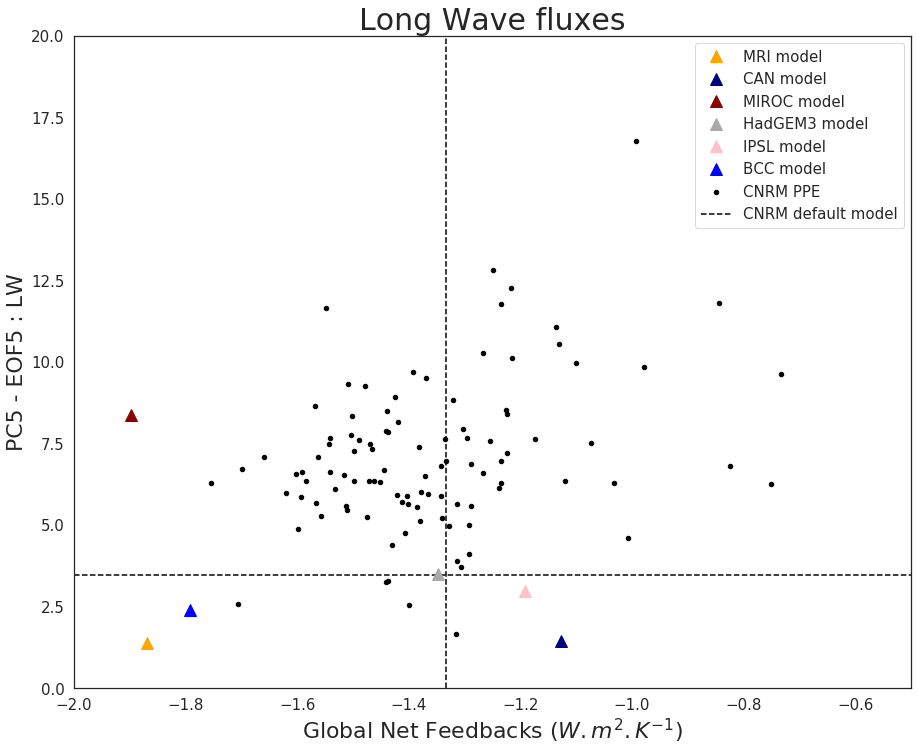

In [110]:
ax = plt.gca()

E_PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)
plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)


plt.hlines(E_p1,xmin = -2.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = 0,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

legend = ['MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model',
          'BCC model', 'CNRM PPE', 'CNRM default model']

title = TITLE
plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(title, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,20)
plt.xlim(-2.0,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

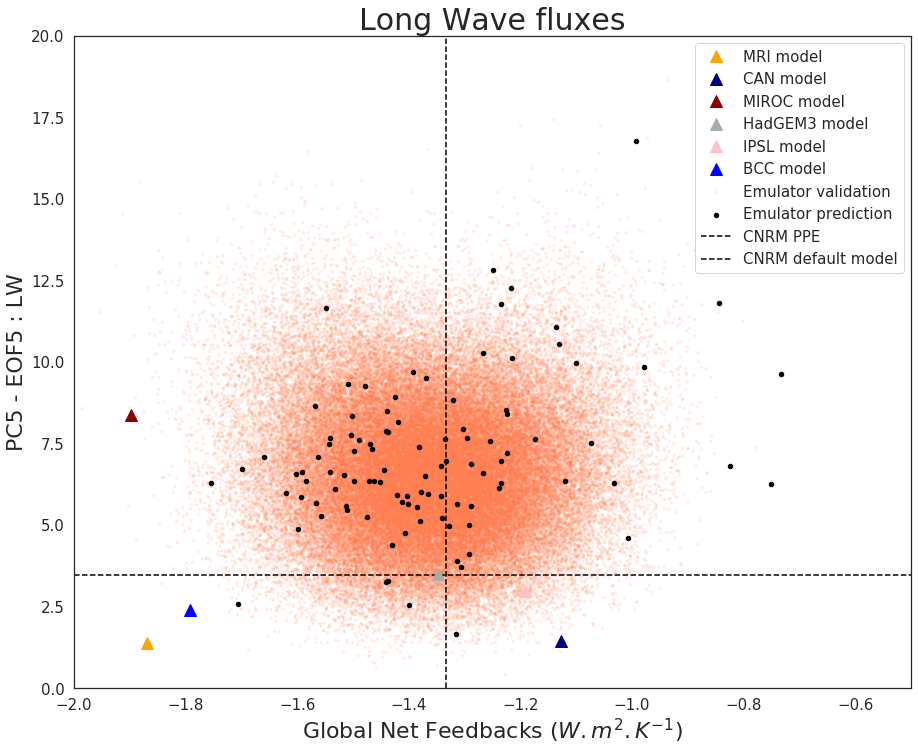

In [112]:
ax = plt.gca()

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

#E_multilinreg_val_df.plot(kind='scatter', x='Fdbck_val', y='E_multilinreg_val', color='red', alpha=1, figsize=(15, 12), 
#                     marker='x', ax = ax)
E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='coral', alpha=0.1, figsize=(15, 12), marker='.', ax = ax)


E_PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -2.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = 0,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

legend = ['MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model',
          'BCC model', 'Emulator validation', 'Emulator prediction', 'CNRM PPE', 'CNRM default model']

title = TITLE
plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(title, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,20)
plt.xlim(-2.0,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_pred.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [113]:
fluxes_biases = E_PPE_df
fluxes_biases['E_multilinreg_val'] = E_multilinreg_val_df['E_multilinreg_val']
fluxes_biases['OSE_multilinreg'] = abs(fluxes_biases['E_PPE'] - fluxes_biases['E_multilinreg_val'])
fluxes_biases

,E_PPE,Fdbck,E_multilinreg_val,OSE_multilinreg
0,6.809218,-0.825236,4.979821,1.829397
1,7.093494,-1.659636,6.770306,0.323188
2,10.118338,-1.215000,10.118197,0.000141
3,8.833412,-1.321641,8.228008,0.605404
4,6.255715,-0.750397,9.895898,3.640183
...,...,...,...,...
97,6.534499,-1.516367,6.012742,0.521757
98,6.364555,-1.584491,6.344436,0.020120
99,5.239393,-1.474525,4.587477,0.651916
100,6.683621,-1.445422,6.845235,0.161614


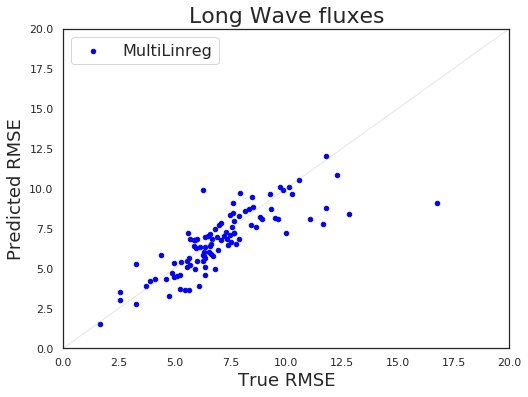

In [114]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title= TITLE 
fluxes_biases.plot(kind='scatter', x='E_PPE', y='E_multilinreg_val', color='blue',  
                     marker="o", ax = ax)
#fluxes_biases.plot(kind='scatter', x='E_PPE', y='E_lasso_val', color='blue', alpha=0.6, 
#                     marker="o", ax = ax)

plt.xlabel('True RMSE', fontsize = 18)#, fontsize=18)
plt.ylabel('Predicted RMSE', fontsize = 18)#, fontsize=18)
plt.legend(['MultiLinreg', 'LASSO'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(0,20)
plt.xlim(0,20)
ax.plot((0,20), (0, 20), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable+"_emulator_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### Save data 

In [115]:
OSE = fluxes_biases['OSE_multilinreg'].mean()
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_'+variable+'.npy', OSE)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy', E_p1)

In [116]:
RMSE_val = fluxes_biases['E_multilinreg_val']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_val_'+variable+'.npy', RMSE_val)

In [117]:
OSE = fluxes_biases['OSE_multilinreg'].mean()
OSE

0.9267510940636671

In [118]:
## SAVE 
OSE = fluxes_biases['OSE_multilinreg'].mean()
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_'+variable+'.npy', OSE)

E_multilinreg_pred = E_multilinreg_pred_df['E_multilinreg_pred'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_'+variable+'.npy', E_multilinreg_pred)

E_PPE = E_PPE_df['E_PPE'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy', E_PPE)

### [Back to the top](#top)

# <a id="histograms">Figure histograms</a> </li>

In [119]:
E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy')
p1_feedback = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")

In [120]:
E_MLR = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_'+variable+'.npy')
Fdbck_MLR = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")
MLR_df=pd.DataFrame(E_MLR, columns=['E_MLR'])
MLR_df['Fdbck'] = Fdbck_MLR
#MLR_df

In [121]:
E_MLR_short = []
tmp = []
Fdbck_MLR_short = []
cpt=0

for i in MLR_df['E_MLR']:
    if i <= E_p1:
        E_MLR_short.append(i)
        toto = MLR_df['Fdbck'][cpt]
        Fdbck_MLR_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

MLR_short = pd.DataFrame()
MLR_short['Fdbck'] = Fdbck_MLR_short
MLR_short['E_MLR'] = E_MLR_short
MLR_short

,Fdbck,E_MLR
0,-1.410328,2.650914
1,-1.296605,2.833975
2,-1.516957,2.719038
3,-1.408538,2.761409
4,-1.289760,2.794859
...,...,...
4798,-1.377415,3.051208
4799,-1.312518,3.012570
4800,-1.304013,2.198755
4801,-1.357204,2.498845


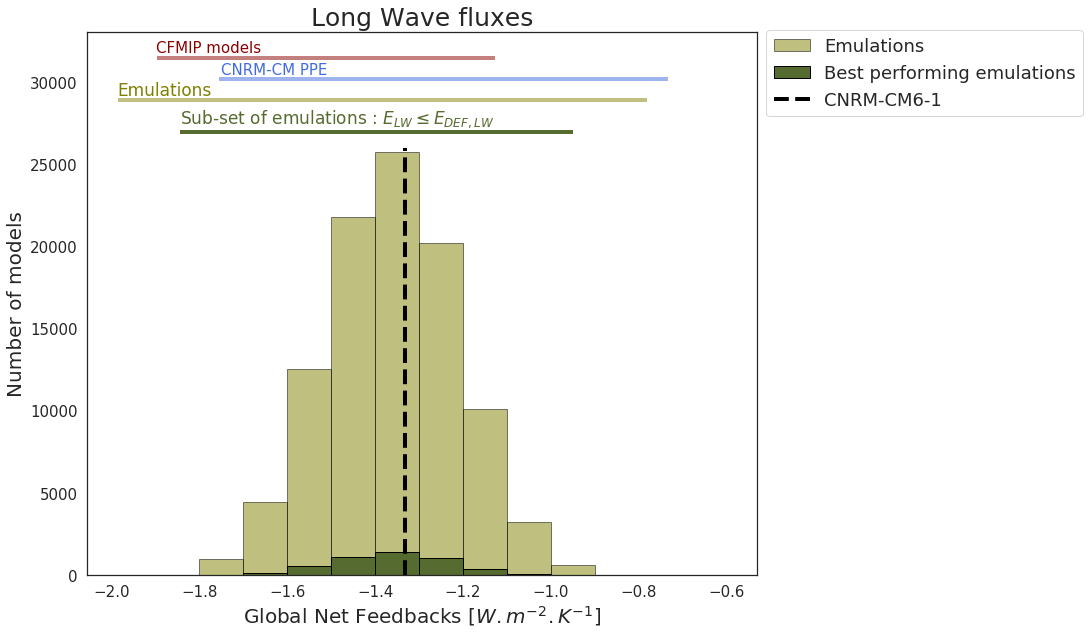

In [122]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_MLR, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'olive', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(MLR_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'darkolivegreen', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 26000,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(31500.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 31800.0, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(30200.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 30500.0, 'CNRM-CM PPE', color = 'royalblue', fontsize=15)

plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(27000.0,xmin = MLR_short['Fdbck'].min(),xmax = MLR_short['Fdbck'].max(),
           colors='darkolivegreen', linewidth=4.0, linestyles='solid')
plt.text(MLR_short['Fdbck'].min(), 27500.0, 'Sub-set of emulations : $E_{LW}\leq E_{DEF,LW}$', 
         color = 'darkolivegreen', fontsize=17)

legend=['Emulations', 'Best performing emulations', 'CNRM-CM6-1']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title(TITLE, fontsize = 25)
plt.xlabel('Global Net Feedbacks [$W.m^{-2}.K^{-1}$]',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

In [123]:
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')
PPE_df=pd.DataFrame(E_PPE, columns=['E_PPE'])
PPE_df['Fdbck'] = Fdbck_PPE
#PPE_df

In [124]:
E_PPE_short = []
tmp = []
Fdbck_PPE_short = []
cpt=0

for i in PPE_df['E_PPE']:
    if i <= E_p1:
        E_PPE_short.append(i)
        toto = PPE_df['Fdbck'][cpt]
        Fdbck_PPE_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

PPE_short = pd.DataFrame()
PPE_short['Fdbck'] = Fdbck_PPE_short
PPE_short['E_PPE'] = E_PPE_short
#PPE_short

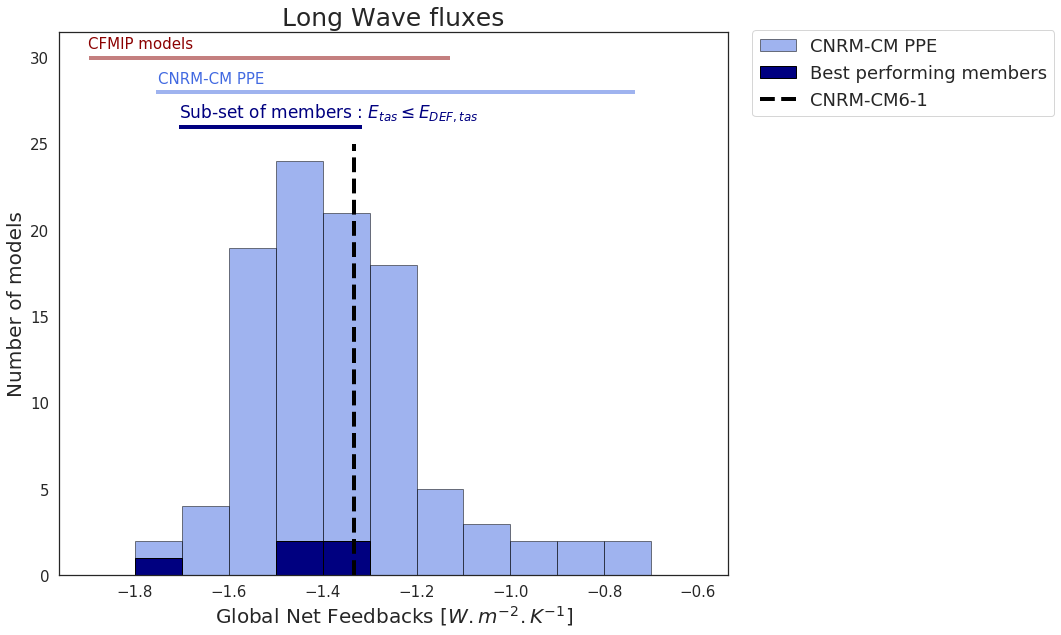

In [125]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_PPE, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'royalblue', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(PPE_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'navy', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 25,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(30.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 30.5, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(28.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 28.5, 'CNRM-CM PPE', color = 'royalblue', fontsize=15)

#plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
#           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
#plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(26.0,xmin = PPE_short['Fdbck'].min(),xmax = PPE_short['Fdbck'].max(),
           colors='navy', linewidth=4.0, linestyles='solid')
plt.text(PPE_short['Fdbck'].min(), 26.5, 'Sub-set of members : $E_{tas}\leq E_{DEF,tas}$', 
         color = 'navy', fontsize=17)

legend=['CNRM-CM PPE', 'Best performing members', 'CNRM-CM6-1']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title(TITLE, fontsize = 25)
plt.xlabel('Global Net Feedbacks [$W.m^{-2}.K^{-1}$]',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_"+variable+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### [Back to the top](#top)

# <a id="optim">Step 5 - Optimisation</a> </li>

The objective here is to optimize the emulators described above in order to obtain a sub-set of the best parametrizations for each bins of feedback values. In other words, we aim to fine the parametrization which minimizes the error $E_{tot}$ given by the control mean state emulator, while showing a global net feedback value predicted by the feedback emulator within a chosen bin. It is a case of linear minimization with constraint and the optimizer used here comes from the SciPy Python's library and uses sequential least squares programming (SLSQP).

### Functions 

In [126]:
N_error = 128*256

In [127]:
def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/N_error)
    return E

In [128]:
# FONCTIONS RMSE

def function_RMSE_emulator_std(x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_emulator(x, variable): 
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable)
    return E

# FONCTIONS FEEDBACKS

def em_fdb_std(x) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def em_fdb(x) :
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    y_pred = em_fdb_std(x_std)
    return y_pred

In [129]:
# FONCTION JACOBIAN

def jacobian(x, variable) :
    
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    
    Beta1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta1.npy')
    Beta2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta2.npy')
    Beta3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta3.npy')
    Beta4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta4.npy')
    Beta5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta5.npy')
    
    R1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R1.npy')
    R2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R2.npy')
    R3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R3.npy')
    R4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R4.npy')
    R5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R5.npy')
    
    C1 = R1 - U_obs[0]
    C2 = R2 - U_obs[1]
    C3 = R3 - U_obs[2]
    C4 = R4 - U_obs[3]
    C5 = R5 - U_obs[4]
    
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    A = x_std*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + (Beta1*C1 + Beta2*C2 + Beta3*C3 + 
                                                                    Beta4*C4 + Beta5*C5)
    
    tmp = x_std**2*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + 2*x_std*(Beta1*C1 + Beta2*C2 + Beta3*C3 + Beta4*C4 + Beta5*C5) +(C1**2+C2**2+C3**2+C4**2+C5**2)
    B = sqrt(tmp)
    
    D = 1/sqrt(N_error)
    
    jac = (A/B)*D
    
    return jac


# FONCTIONS CONTRAINTES

def constraint1(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (tmp-fdb_low)
    return test

def constraint2(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (fdb_hi-tmp)
    return test


# FONCTIONS OPTIMISATION

def Optimization(x_best, ind, xlim, variable) :
    
    sol_list=[]
    sol_fdbck=[]
    sol_x=[]
    n = len(x_best)
    cpt=0
    
    for i in range(0, n, 1) :
        x0 = x_best[i]
   
        fdb_low = em_fdb(x0)-ind
        #print('low = '+str(fdb_low))
        fdb_hi = em_fdb(x0)+ind
        #print('hi = '+str(fdb_hi))

        fdb_x0 = em_fdb(x0)
        #print('fdb_x0 = '+str(fdb_x0))
        fun_x0 = function_RMSE_emulator(x0, variable)
        #print('fun_x0 = '+str(fun_x0))

        cons1 = {'type': 'ineq', 'fun' : constraint1, 'args' : [fdb_low, fdb_hi]}
        cons2 = {'type': 'ineq', 'fun' : constraint2, 'args' : [fdb_low, fdb_hi]}
    
        sol = minimize(function_RMSE_emulator,  x0, args=(variable), method='SLSQP', bounds=xlim, constraints=(cons1, cons2), 
                   jac = jacobian, options={'disp': True}, tol = 0.001)    
                        # , 'maxiter' : 250   jac = jacobian,
    

        tmp_fun = function_RMSE_emulator(sol.x, variable)
        tmp_fdbck = em_fdb(sol.x)
        #print('fdb_x = '+str(tmp_fdbck))
    
        sol_list.append(tmp_fun)
        sol_fdbck.append(tmp_fdbck)
        sol_x.append(sol.x)
    
    sol_df = pd.DataFrame()
    sol_df['sol_fun'] = sol_list[:]
    sol_df['Fdbck'] = sol_fdbck[:]
    j=1
    for i in range(0, 30, 1) :
        #print(j)
        sol_df['x'+str(j)+'_smth_0'] = (transpose(sol_x)[i])
        j+=1
    
    return sol_df

In [130]:
def smooth(n, df1, df2):

    for i in range(1,31,1) :
        tmp_x =[df1['x'+str(i)+'_smth_'+str(n-1)][0]]

        for j in range(1,len(df1)-1, 1) : 
            tmp = 0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j-1]+0.5* \
            df1['x'+str(i)+'_smth_'+str(n-1)][j]+0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j+1]
            
            tmp_x.append(tmp)
    
        tmp_x.append(df1['x'+str(i)+'_smth_'+str(n-1)][(len(df1)-1)])
        
        df2['x'+str(i)+'_smth_'+str(n)] = tmp_x

    return df2

### Get the data

In [131]:
E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy')
E_p1

array(3.45993611)

In [132]:
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')

E_PPE_df = pd.DataFrame()
E_PPE_df['Fdbck'] = Fdbck_PPE
E_PPE_df['RMSE'] = E_PPE
E_PPE_df

,Fdbck,RMSE
0,-0.825236,6.809218
1,-1.659636,7.093494
2,-1.215000,10.118338
3,-1.321641,8.833412
4,-0.750397,6.255715
...,...,...
97,-1.516367,6.534499
98,-1.584491,6.364555
99,-1.474525,5.239393
100,-1.445422,6.683621


In [133]:
E_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_"+variable+".npy")
Fdbck_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")


E_multilinreg_pred_df = pd.DataFrame(E_multilinreg_pred)
E_multilinreg_pred_df['E_multilinreg_pred'] = E_multilinreg_pred
E_multilinreg_pred_df['Fdbck_pred'] = Fdbck_multilinreg_pred[0:100000]
E_multilinreg_pred_df = E_multilinreg_pred_df.drop([0], axis=1)
E_multilinreg_pred_df

,E_multilinreg_pred,Fdbck_pred
0,4.496589,-1.499698
1,5.598323,-1.339351
2,5.905107,-1.323732
3,9.310045,-1.541909
4,4.844026,-1.346961
...,...,...
99995,6.327942,-1.453679
99996,5.864764,-1.410350
99997,5.497670,-1.296397
99998,4.468051,-1.299809


### Initial guess for Optimization 1

In [134]:
E_multilinreg_pred_df['Fdbck_pred_round'] = E_multilinreg_pred_df['Fdbck_pred'].round(decimals=2)
E_multilinreg_pred_df = E_multilinreg_pred_df.set_index('Fdbck_pred_round')
E_multilinreg_pred_df['members'] = range(0,100000,1) 
#E_multilinreg_pred_df        

In [135]:
new_df=pd.DataFrame()
new_df['E_multilinreg_pred_best'] = E_multilinreg_pred_df['E_multilinreg_pred'].groupby('Fdbck_pred_round').min()
new_df = new_df.reset_index()
#new_df

In [136]:
list_RMSE = new_df['E_multilinreg_pred_best']
n = len(list_RMSE)

tmp_fdbck = []
tmp_member = []
tmp_pc1 = []
cpt=0
ind=0
cpt_other=0
for i in E_multilinreg_pred_df['E_multilinreg_pred'] :
    for j in list_RMSE :
        if i==j:
            #print(cpt)
            tmp_fdbck.append(E_multilinreg_pred_df['Fdbck_pred'].iloc[cpt])
            tmp_member.append(E_multilinreg_pred_df['members'].iloc[cpt])
        else :
            cpt_other+=1
    cpt+=1

fdbck = [k for k in tmp_fdbck if k != 0]
members = [l for l in tmp_member if l != 0]
pc1 = [l for l in tmp_pc1 if l != 0]

df = pd.DataFrame()
df['fdbck'] = fdbck
df['members'] = members
df_sort = df.sort_values(by=['fdbck']).reset_index().drop('index', axis=1)
df_sort

new_df['Fdbck_pred'] = df_sort['fdbck']
new_df['members'] = df_sort['members']
#new_df

### Optimization 1 

In [137]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")

x_best = []
for i in new_df['members']:
    #print(i)
    x_best.append(LHS[i])

x_best=np.array(x_best)
#x_best

In [138]:
param = pd.read_csv("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
#xlim

In [139]:
sol_df = Optimization(x_best, 0.0001, xlim, variable)
#sol_df

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.283742080314324
            Iterations: 3
            Function evaluations: 14
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.505824029523327
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.93689593725805
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.316964985440244
            Iterations: 3
            Function evaluations: 14
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.051200964912507
            Iterations: 3
            Function evaluations: 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3790919289310117
            Iterations: 3
            Function evaluations: 16
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.44825720342340414
            Iterations: 4
            Function evaluations: 20
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3850125208269943
            Iterations: 3
            Function evaluations: 17
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0003509151205419
            Iterations: 3
            Function evaluations: 18
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2631245254834795
            Iterations: 3
            Function evalua

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2621822007147108
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1459374578386619
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4243292954679219
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.7581376151514476
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.307609008091916
            Iterations: 3
            Function evaluati

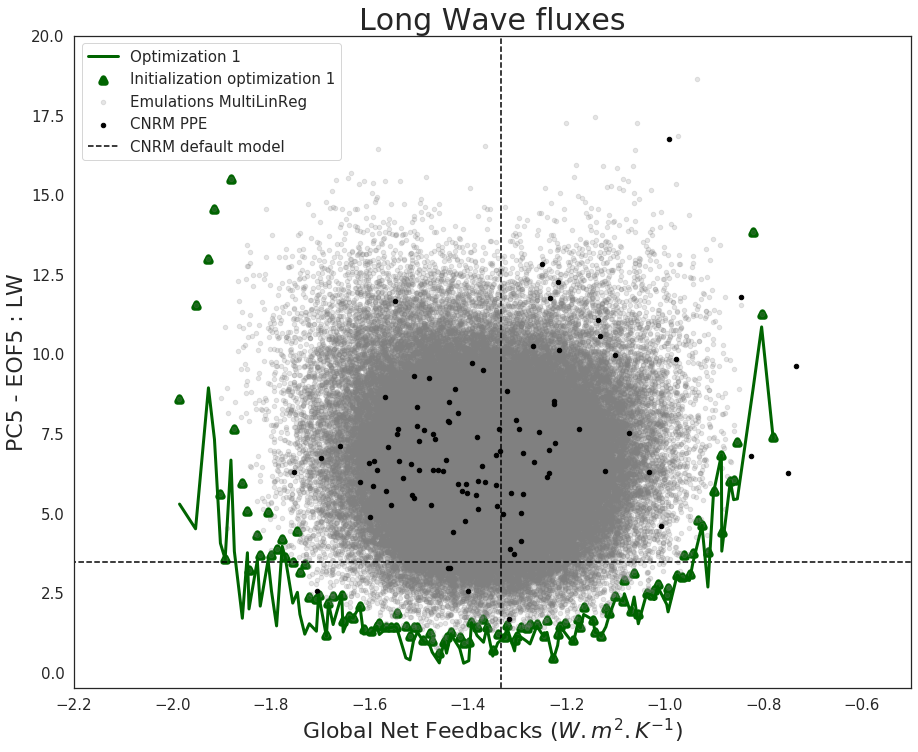

In [140]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', 
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
         linewidth=3, ax = ax)

E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Optimization 1', 'Initialization optimization 1', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-0.5,20)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim1.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Initial guess for Optimization 2 (param. smoothing)

In [141]:
new_sol_df = pd.DataFrame()
new_sol_df['Fdbck'] = sol_df['Fdbck']

new_sol_df = smooth(1, sol_df, new_sol_df)

n = 151
for i in range(2,n,1) :
    new_sol_df = smooth(i, new_sol_df, new_sol_df)
    
new_sol_df

,Fdbck,x1_smth_1,x2_smth_1,x3_smth_1,x4_smth_1,x5_smth_1,x6_smth_1,x7_smth_1,x8_smth_1,x9_smth_1,...,x21_smth_150,x22_smth_150,x23_smth_150,x24_smth_150,x25_smth_150,x26_smth_150,x27_smth_150,x28_smth_150,x29_smth_150,x30_smth_150
0,-1.985856,0.060000,0.500000,0.500000,29.531266,-0.010000,6.470853,2.810467,0.000500,0.001000,...,-2.098292,-25.000000,0.100000,11.429280,0.000010,0.664140,0.500002,0.590519,0.500000,4.624869
1,-1.953241,0.060000,0.500000,1.388784,23.540183,-0.010000,7.134646,3.955858,0.000501,0.001000,...,-2.132174,-25.572344,0.098226,11.400824,0.000011,0.674607,0.507799,0.603413,0.503133,4.460557
2,-1.927100,0.060000,0.500000,0.944392,22.757120,-0.010000,7.273948,2.359940,0.002875,0.000872,...,-2.165598,-26.130607,0.096476,11.370603,0.000012,0.684829,0.515556,0.616149,0.506258,4.299682
3,-1.914873,0.068577,0.523760,0.564974,23.023724,-0.019276,6.724202,2.353080,0.006720,0.000743,...,-2.198134,-26.661432,0.094773,11.336949,0.000014,0.694575,0.523233,0.628576,0.509365,4.145544
4,-1.902763,0.080932,0.590720,0.939113,19.766211,-0.092553,7.111695,5.488723,0.006431,0.000784,...,-2.229399,-27.152858,0.093136,11.298380,0.000015,0.703636,0.530797,0.640552,0.512447,4.001172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.860410,0.162544,2.220627,1.349981,9.930691,-0.282067,2.446978,6.256184,0.003919,0.000155,...,-2.579718,-45.297418,0.017686,7.139884,0.000054,0.584025,0.582857,0.910873,0.853161,6.651572
109,-0.852841,0.083834,2.002361,0.840668,13.066379,-0.148312,1.379304,6.287456,0.004072,0.000081,...,-2.562406,-45.797843,0.017613,7.680909,0.000053,0.572335,0.573615,0.927808,0.865382,6.925911
110,-0.820749,0.085806,1.750015,0.661007,17.742133,-0.150250,0.414209,5.124033,0.007300,0.000112,...,-2.544013,-46.313771,0.017530,8.241859,0.000051,0.560138,0.564080,0.945272,0.878129,7.206603
111,-0.803544,0.161148,1.828665,0.934141,22.318534,-0.204816,0.508630,4.617706,0.008840,0.000330,...,-2.524862,-46.840691,0.017441,8.816519,0.000049,0.547589,0.554343,0.963095,0.891242,7.491596


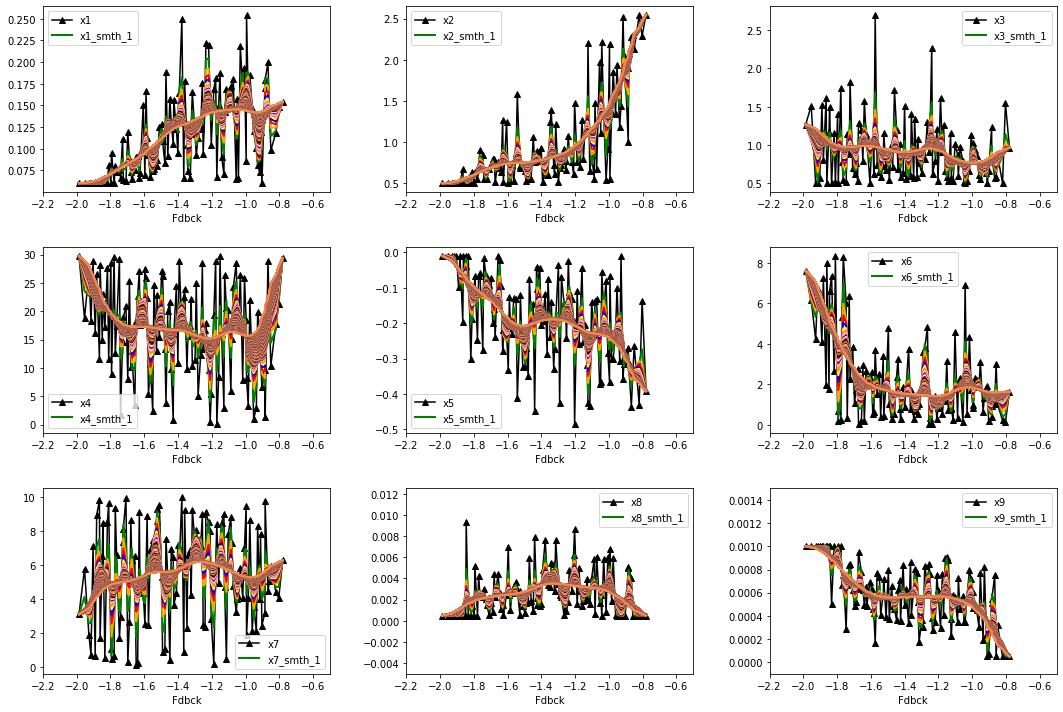

In [89]:
# SETTINGS ------------------

n = 150

colors = ['black', 'green', 'orange', 'red', 'blue', 'yellow', 'coral', 'pink', 'purple', 'white','red']*100

# Plot of lines from different dataframes
plt.subplots(figsize=(15,10)) 

plt.subplot(331)

ax1 = plt.gca()
title = 'parameter 1'

sol_df.plot(kind='line', x='Fdbck', y='x1_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax1)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x1_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax1)

plt.xlim(-2.2,-0.5)
plt.legend(['x1', 'x1_smth_1'])
plt.subplot(332)

ax2 = plt.gca()
title = 'parameter 2'

sol_df.plot(kind='line', x='Fdbck', y='x2_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax2)
for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x2_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax2)

plt.xlim(-2.2,-0.5)
plt.legend(['x2', 'x2_smth_1'])
plt.subplot(333)

ax3 = plt.gca()
title = 'parameter 3'

sol_df.plot(kind='line', x='Fdbck', y='x3_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax3)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x3_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax3)

plt.xlim(-2.2,-0.5)
plt.legend(['x3', 'x3_smth_1'])
plt.subplot(334)

ax4 = plt.gca()
title = 'parameter 4'

sol_df.plot(kind='line', x='Fdbck', y='x4_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax4)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x4_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax4)

plt.xlim(-2.2,-0.5)
plt.legend(['x4', 'x4_smth_1'])
plt.subplot(335)

ax5 = plt.gca()
title = 'parameter 5'

sol_df.plot(kind='line', x='Fdbck', y='x5_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax5)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x5_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax5)

plt.xlim(-2.2,-0.5)
plt.legend(['x5', 'x5_smth_1'])
plt.subplot(336)

ax6 = plt.gca()
title = 'parameter 6'

sol_df.plot(kind='line', x='Fdbck', y='x6_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax6)

for i in range(1,n,1) : 
    new_sol_df.plot(kind='line', x='Fdbck', y='x6_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax6)
    
plt.xlim(-2.2,-0.5)
plt.legend(['x6', 'x6_smth_1'])
plt.subplot(337)

ax7 = plt.gca()
title = 'parameter 7'

sol_df.plot(kind='line', x='Fdbck', y='x7_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax7)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x7_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax7)

plt.xlim(-2.2,-0.5)
plt.legend(['x7', 'x7_smth_1'])
plt.subplot(338)

ax8 = plt.gca()
title = 'parameter 8'

sol_df.plot(kind='line', x='Fdbck', y='x8_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax8)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x8_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax8)

plt.ylim(-0.005,0.0125)
plt.xlim(-2.2,-0.5)
plt.legend(['x8', 'x8_smth_1'])
plt.subplot(339)

ax9 = plt.gca()
title = 'parameter 9'

sol_df.plot(kind='line', x='Fdbck', y='x9_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax9)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x9_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax9)

plt.ylim(-0.0001,0.0015)
plt.xlim(-2.2,-0.5)
plt.legend(['x9', 'x9_smth_1'])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/longPPE_N_tas_future4K.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Optimization 2

In [142]:
x_best_2 = pd.DataFrame()
for k in range(1,31,1) : 
    x_best_2['x'+str(k)+'_best'] = new_sol_df['x'+str(k)+'_smth_150']

x_best_2 = x_best_2.to_numpy()
x_best_2

array([[0.06      , 0.5       , 0.5       , ..., 0.59051914, 0.5       ,
        4.62486909],
       [0.06087295, 0.5080769 , 0.542149  , ..., 0.6034129 , 0.50313348,
        4.46055677],
       [0.06174271, 0.51610247, 0.58377493, ..., 0.61614905, 0.50625793,
        4.29968195],
       ...,
       [0.24261984, 2.50960323, 1.14418599, ..., 0.94527187, 0.87812947,
        7.20660267],
       [0.25034042, 2.58612014, 1.12330144, ..., 0.96309539, 0.89124151,
        7.49159624],
       [0.25814517, 2.66303813, 1.10214544, ..., 0.98110139, 0.9045396 ,
        7.77876145]])

In [143]:
init_df = pd.DataFrame()
init_df['Fdbck'] = sol_df['Fdbck']

tmp_fun = []
for i in x_best_2 :
    tmp = function_RMSE_emulator(i, variable)
    tmp_fun.append(tmp)
init_df['RMSE'] = tmp_fun
init_df

,Fdbck,RMSE
0,-1.985856,5.283742
1,-1.953241,5.039780
2,-1.927100,4.798032
3,-1.914873,4.559779
4,-1.902763,4.326146
...,...,...
108,-0.860410,5.892984
109,-0.852841,6.240628
110,-0.820749,6.598990
111,-0.803544,6.965801


In [144]:
sol_df_2 = Optimization(x_best_2, 0.0001, xlim, variable)
#sol_df_2

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.283746420592845
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.039785198924043
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.7980334640368065
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.559779609782002
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.326145973144042
            Iterations: 1
            Function evaluations

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6869457903884749
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6579845246296898
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6306415410986408
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6054729587473222
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5830009096105444
            Iterations: 1
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2655310635689885
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.329153091996809
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3949665404485094
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.463178840248766
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.5341206637604983
            Iterations: 1
            Function evaluatio

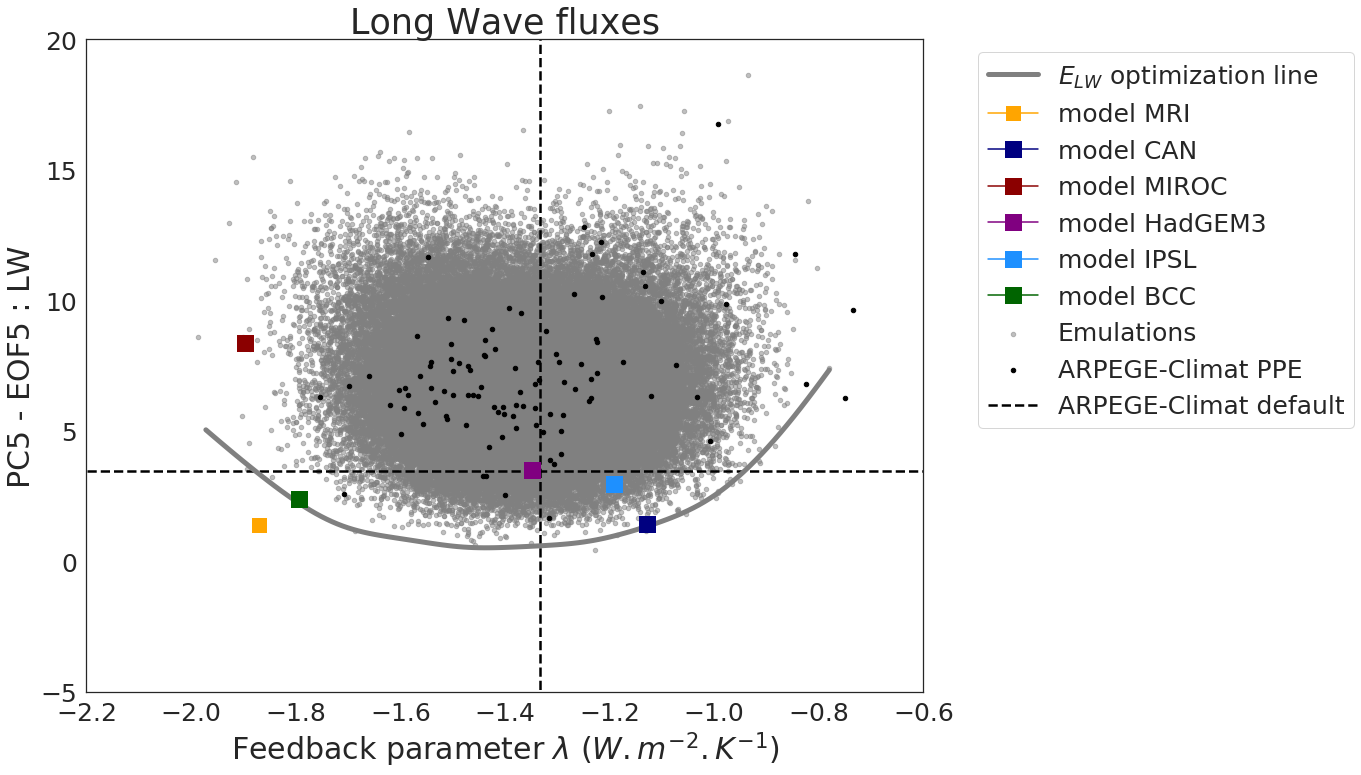

In [147]:
colors = ['coral','blue','orange','black','green','red','purple','yellow','cornflowerblue']
cpt=0

ax = plt.gca()

#new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', alpha=0.3,
#         marker = '^', linewidth=6,  ax = ax)

#init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkgreen', alpha=1,
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', alpha=0.3,
#         linewidth=3, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'gray', alpha=1, linewidth=5, ax = ax)

E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.5, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), alpha=1.0,
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='s', markeredgewidth=0, markersize=15, zorder=20)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='s', markeredgewidth=2, markersize=15, zorder=30)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='purple', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_IPSL, E_IPSL, color='dodgerblue', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_BCC, E_BCC, color='darkgreen', marker='s', markeredgewidth=2, markersize=15, zorder=20)


legend = [ '$E_{LW}$ optimization line', 'model MRI','model CAN','model MIROC','model HadGEM3','model IPSL', 'model BCC', 
          'Emulations','ARPEGE-Climat PPE', 'ARPEGE-Climat default']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=30)
plt.ylabel(ylabel, fontsize=30)
plt.legend(legend, fontsize=25, bbox_to_anchor=(1.05, 1))

plt.title(TITLE, fontsize=35)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylim(-5,20)
plt.xlim(-2.2,-0.6)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save data

In [146]:
RMSE_optim2 = sol_df_2['sol_fun']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+variable+'.npy', RMSE_optim2)

Fdbck_optim2 = sol_df_2['Fdbck']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+variable+'.npy', Fdbck_optim2)

### [Back to the top](#top)

# <a id="selection">Step 6 - Optimal subset of parameters</a> </li>

## Projection of sub-set on EOF basis

### Settings 

In [19]:
ENSEMBLE = 'ENSEMBLE4_selection/'
path_PPE_short = '/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
product = 'CERES'

In [20]:
nb_p_select = ['p840', 'p841', 'p842', 'p843','p844', 'p845', 'p846', 'p847']
len(nb_p_select)

8

In [21]:
N_error=128*256

### Functions

In [22]:
def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/N_error)
    return E

In [23]:
def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred


# FONCTIONS RMSE

def function_RMSE_emulator_std(x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_emulator(x, variable): 
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable)
    return E

### EOF, tas_mean and PCs

In [24]:
Mean =  pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
#Mean

### Get the subset data

In [25]:
E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy')
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')

## Error estimate in ARPEGE-Climat

In [27]:
E_df_selection=[]
for i in nb_p_select :
    U = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/U_'+i+'_'+variable+'.npy')
    pc1 = U[0]
    pc2 = U[1]
    pc3 = U[2]
    pc4 = U[3]
    pc5 = U[4]
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    E_df_selection.append(E)

E_df_selection

[6.3133133270922,
 6.610591001348201,
 5.50608887600766,
 5.446166279484329,
 5.540701019094109,
 5.055891396760911,
 4.935113135987308,
 7.535454966665921]

In [28]:
Fdbck_selection = np.load('/data/home/globc/peatier/CNRMppe/PPE/'+ENSEMBLE+'files/npy/QUAT_Net_feedbacks.npy')
Fdbck_selection

array([-1.69343424, -1.7067678 , -1.61947143, -1.50831775, -1.41209233,
       -1.13269941, -0.87172544, -0.56140771])

## Error estimate with emulator

In [29]:
file = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_select.npy')
df_select = pd.DataFrame(file).drop([8])
df_select

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1.776953,-1.985756,0.060000,0.782793,2.142053,29.775351,-0.010000,8.664463,3.020343,0.000500,...,-2.471254,-25.266850,0.045748,13.661456,0.000010,0.913490,0.620287,0.500000,0.500000,6.042944
1,1.261023,-1.793487,0.092451,0.775988,1.835889,16.677694,-0.095253,6.666214,4.508329,0.003164,...,-2.837226,-32.421030,0.057842,11.727646,0.000038,0.882939,0.742863,0.639256,0.586545,4.707199
2,0.974675,-1.639187,0.114980,0.869206,1.792741,16.898659,-0.112145,4.443179,4.174728,0.005127,...,-2.700198,-33.902888,0.059850,8.234620,0.000054,0.863454,0.761513,0.711625,0.627510,4.275389
3,0.814275,-1.489048,0.136523,1.109424,1.903055,17.453172,-0.100000,3.078862,3.825227,0.005717,...,-2.430384,-32.707234,0.055823,4.995179,0.000059,0.828581,0.718952,0.752331,0.673440,4.086714
4,0.720396,-1.338640,0.150080,1.262510,1.727699,16.548401,-0.131147,2.672060,4.260765,0.004969,...,-2.419481,-33.721094,0.035107,3.799664,0.000061,0.842050,0.684948,0.758052,0.700458,4.511644
5,0.694808,-1.188343,0.160636,1.537920,1.523233,12.986488,-0.175298,2.495307,4.327776,0.005232,...,-2.658346,-35.855889,0.025262,3.291661,0.000064,0.782844,0.697536,0.731226,0.732272,4.363352
6,0.718234,-1.038806,0.163307,1.828007,1.512815,13.946728,-0.216507,2.336977,3.425777,0.005186,...,-2.648154,-38.136234,0.019986,2.696607,0.000062,0.678240,0.709589,0.734188,0.753012,4.404452
7,1.221805,-0.873181,0.165083,2.219252,1.360215,19.891069,-0.339322,1.793060,4.713772,0.005150,...,-2.599949,-43.551279,0.015234,5.622651,0.000069,0.616350,0.623375,0.821796,0.793923,5.837056


In [30]:
file = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_total.npy')
df_optim_total = pd.DataFrame(file)
df_optim_total

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1.776953,-1.985756,0.060000,0.782793,2.142053,29.775351,-0.010000,8.664463,3.020343,0.000500,...,-2.471254,-25.266850,0.045748,13.661456,0.000010,0.913490,0.620287,0.500000,0.500000,6.042944
1,1.762960,-1.971606,0.060000,0.771711,2.109585,28.387070,-0.010000,8.517878,3.179734,0.000500,...,-2.506757,-25.984719,0.042037,13.524081,0.000010,0.909729,0.629001,0.500000,0.500000,5.884610
2,1.747476,-1.957607,0.064617,0.828770,2.153730,27.047637,-0.044442,8.500317,3.359057,0.000905,...,-2.561124,-26.715433,0.043889,13.598473,0.000015,0.903923,0.654323,0.520200,0.512286,5.773078
3,1.701060,-1.943609,0.066933,0.817078,2.120559,25.715006,-0.049635,8.352687,3.511770,0.001104,...,-2.595572,-27.401009,0.045458,13.461733,0.000017,0.899978,0.663194,0.530337,0.518452,5.622744
4,1.655735,-1.929758,0.069233,0.806180,2.088401,24.436898,-0.054642,8.205983,3.657854,0.001300,...,-2.628760,-28.054637,0.046972,13.325501,0.000020,0.896328,0.671872,0.540407,0.524583,5.480335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1.455842,-0.834215,0.157016,2.346720,1.264706,23.537382,-0.364038,1.787752,5.313115,0.005856,...,-2.563512,-45.052371,0.014225,7.069913,0.000073,0.596186,0.587515,0.871901,0.797610,6.606023
109,1.448764,-0.820870,0.119989,2.328477,1.221399,24.918576,-0.359082,1.792622,5.529209,0.007510,...,-2.542609,-45.587788,0.012499,7.554453,0.000084,0.600643,0.569731,0.880656,0.760203,6.873109
110,1.618494,-0.807407,0.060000,2.270250,1.173089,26.355960,-0.346376,1.799802,5.749377,0.010000,...,-2.517253,-46.132130,0.010000,8.023230,0.000100,0.612746,0.548887,0.883723,0.698772,7.139820
111,1.701626,-0.793798,0.060000,2.325438,1.140221,27.850900,-0.357062,1.806978,5.987342,0.010000,...,-2.501056,-46.721158,0.010000,8.589710,0.000100,0.602930,0.536530,0.904800,0.706588,7.436392


In [31]:
E_emulator_selection = []
for i in range(0,len(df_select),1) :
    x = df_select.iloc[i][2:]
    E = function_RMSE_emulator(x, variable)
    E_emulator_selection.append(E)

E_emulator_selection

[6.353074642050998,
 3.1400887250435447,
 2.02256765428402,
 1.6637324531178084,
 1.4569766631115897,
 1.6640181343729432,
 2.309543769282947,
 5.3325731910625755]

In [32]:
E_optim_total = []
for i in range(0,len(df_optim_total),1) :
    x = df_optim_total.iloc[i][2:]
    E = function_RMSE_emulator(x, variable)
    E_optim_total.append(E)
    
E_optim_total

[6.353074642050998,
 6.246252654976832,
 6.121914650858806,
 5.816119502184214,
 5.518388800690287,
 5.230701188469983,
 4.9547761301150715,
 4.692098320382566,
 4.443865042727112,
 4.210946154809729,
 3.9938585834345433,
 3.792758927402304,
 3.60745692328616,
 3.437450258326271,
 3.2819781908790966,
 3.1400887250435447,
 3.0107120123398468,
 2.8927320512242147,
 2.78504966532352,
 2.6866317929445405,
 2.596544732800781,
 2.5139714707763625,
 2.438215057681082,
 2.3686910255323137,
 2.3049120837398513,
 2.2464680849092984,
 2.1930037872852655,
 2.1441965009888975,
 2.099735396914767,
 2.059304058289479,
 2.02256765428402,
 1.9891657803522973,
 1.9587114630051412,
 1.930796087300793,
 1.9049991986427168,
 1.8809014451499215,
 1.8580985483160855,
 1.836214234269881,
 1.8149105320280232,
 1.793894642971925,
 1.7729225168007279,
 1.7518001072824037,
 1.7303838167507897,
 1.7085817264431908,
 1.6863568044833663,
 1.6637324531178084,
 1.6407996763125254,
 1.6177240664526704,
 1.5947499976329

In [33]:
RMSE_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+variable+'.npy')
Fdbck_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+variable+'.npy')
sol_df_2=pd.DataFrame(RMSE_optim_line)
sol_df_2['sol_fun'] = sol_df_2[0]
sol_df_2['Fdbck'] = Fdbck_optim_line
sol_df_2

,0,sol_fun,Fdbck
0,5.283746,5.283746,-1.985856
1,5.039785,5.039785,-1.971730
2,4.798033,4.798033,-1.957656
3,4.559780,4.559780,-1.943682
4,4.326146,4.326146,-1.929855
...,...,...,...
108,5.892991,5.892991,-0.834154
109,6.240643,6.240643,-0.820776
110,6.599007,6.599007,-0.807264
111,6.965814,6.965814,-0.793660


In [34]:
df_optim_total_final= pd.DataFrame(E_optim_total, columns=['RMSE'])
df_optim_total_final['Fdbck']= df_optim_total[1]
df_optim_total_final

,RMSE,Fdbck
0,6.353075,-1.985756
1,6.246253,-1.971606
2,6.121915,-1.957607
3,5.816120,-1.943609
4,5.518389,-1.929758
...,...,...
108,6.767793,-0.834215
109,6.563891,-0.820870
110,7.444506,-0.807407
111,8.014348,-0.793798


In [35]:
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
PPE_df=pd.DataFrame(E_PPE, columns=['E_PPE'])
PPE_df['Fdbck'] = Fdbck_PPE
PPE_df

,E_PPE,Fdbck
0,6.809218,-0.825236
1,7.093494,-1.659636
2,10.118338,-1.215000
3,8.833412,-1.321641
4,6.255715,-0.750397
...,...,...
97,6.534499,-1.516367
98,6.364555,-1.584491
99,5.239393,-1.474525
100,6.683621,-1.445422


## Plot

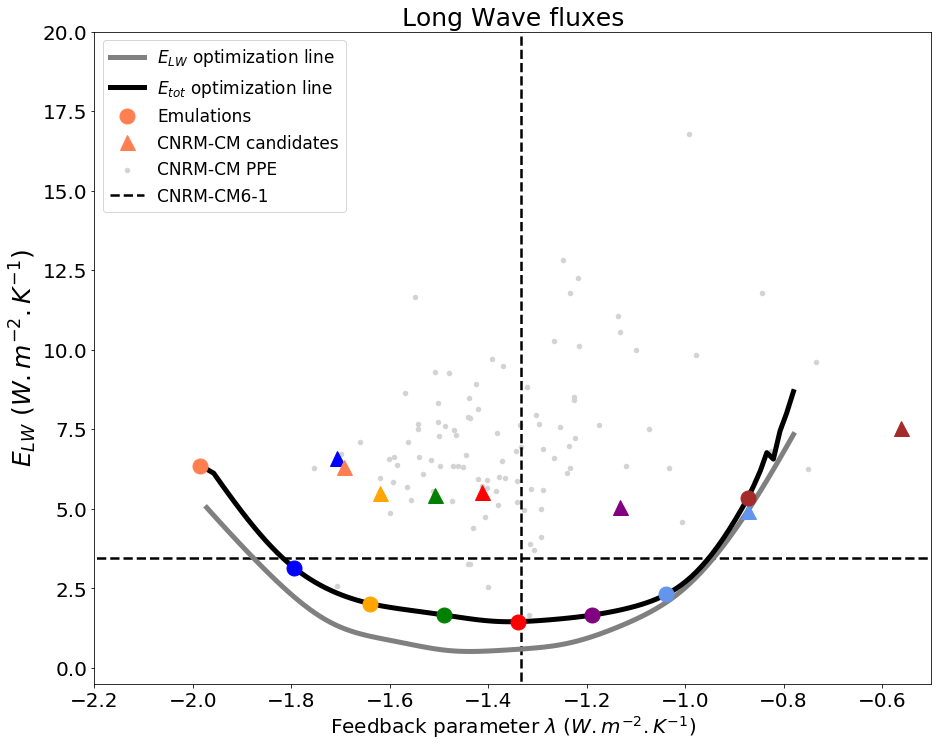

In [41]:
colors = ['coral','blue','orange','green','red','purple','cornflowerblue', 'brown']
cpt=0

ax = plt.gca()

#new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', alpha=0.3,
#         marker = '^', linewidth=6,  ax = ax)

#init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkgreen', alpha=1,
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', alpha=0.3,
#         linewidth=3, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'gray', alpha=1, linewidth=5, figsize=(15, 12), ax = ax)

df_optim_total_final.plot(kind='line', x='Fdbck', y='RMSE', color='black', alpha=1, linewidth=5, ax=ax)

#E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
#                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='lightgray', 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5, zorder=1)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='s', markeredgewidth=0, markersize=15, zorder=20)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='s', markeredgewidth=2, markersize=15, zorder=30)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='s', markeredgewidth=2, markersize=15, zorder=20)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='purple', marker='s', markeredgewidth=2, markersize=15, zorder=20)
#plt.plot(Fdbck_IPSL, E_IPSL, color='dodgerblue', marker='s', markeredgewidth=2, markersize=15, zorder=20)
#plt.plot(Fdbck_BCC, E_BCC, color='darkgreen', marker='s', markeredgewidth=2, markersize=15, zorder=20)


for i in colors :
    if cpt == 0 :
        plt.plot(df_select[1].iloc[cpt], E_emulator_selection[cpt], color=i, marker='o', linewidth=0, markersize=15, zorder=8)

        plt.plot(Fdbck_selection[cpt], E_df_selection[cpt], color=i, marker='^', linewidth=0, markersize=15, zorder=9)
        cpt+=1
    else :
        plt.plot(df_select[1].iloc[cpt], E_emulator_selection[cpt], color=i, marker='o', linewidth=0, markersize=15, label='_nolegend_')

        plt.plot(Fdbck_selection[cpt], E_df_selection[cpt], color=i, marker='^', linewidth=0, markersize=15, label='_nolegend_')
        cpt+=1

legend = [ '$E_{LW}$ optimization line','$E_{tot}$ optimization line', 'Emulations',
          'CNRM-CM candidates', 'CNRM-CM PPE', 'CNRM-CM6-1']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=20)
plt.ylabel(ylabel, fontsize=25)
plt.legend(legend, fontsize=17) #bbox_to_anchor=(1.05, 1)

plt.title(TITLE, fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.ylim(-0.5,20)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_selection.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save the data

In [40]:
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/E_selection_'+variable+'.npy', E_df_selection)

### [Back to the top](#top)

# <a id="correl">Check correlation with simple RMSE</a> </li> 

## Get the data 

In [42]:
# PPE amip simulations 
filename='*_amip_*.nc'


amip={}

for nb_p in nb_p_list :
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_LW_xarr(path, filename, variables)
    

In [43]:
nb_p_select = ['p840', 'p841', 'p842', 'p843','p844', 'p845', 'p846', 'p847']

amip_select={}

for nb_p in nb_p_select :
    path=path_PPE+'ENSEMBLE4_selection/CNRM-CM6-1_amip_PPE_ENSEMBLE4_selection/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    tmp = get_3D_LW_xarr(path, filename, variables)
    amip_select[str(nb_p)] = tmp.assign_coords(lat=amip_list[0]['lat'])
    

In [44]:
path_observation = '/data/scratch/globc/peatier/obs_data/CERES/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'

def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month

    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

# Load data and compute Annual Cycle :
file = xr.open_mfdataset(path_observation+filename,combine='by_coords')
#file
variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path_observation, filename, variables)
df_obs[variable] =  df_obs['toa_lw_all_mon']
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:          (lat: 128, lon: 256)
Coordinates:
  * lat              (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon              (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
Data variables:
    toa_sw_all_mon   (lat, lon) float32 121.35958 121.35958 ... 103.85324
    toa_lw_all_mon   (lat, lon) float32 142.8201 142.8201 ... 194.14125
    toa_net_all_mon  (lat, lon) float32 -91.40278 -91.40278 ... -126.49493
    LW               (lat, lon) float32 142.8201 142.8201 ... 194.14125

In [45]:
# Reference p1
diff = (amip['p1'].values - obs[variable_obs].values)**2
diff_p1 = sqrt(sum(diff)/(128*256))
diff_p1

KeyError: 'p1'

In [47]:
ej = {}
ej_list = []
#ej['p1'] = diff_p1

for p in nb_p_list :
    mod = amip[p]*df_W
    observation = obs[variable]*df_W
    diff_tmp = (mod - observation)**2
    diff = sqrt(diff_tmp['W'].sum(['lat', 'lon'])/(128*256))
    #print(diff_tmp)
    ej[p] = diff
    ej_list.append(float(diff))

In [48]:
df_fig = pd.DataFrame(E_PPE, columns=['E_tas'])
df_fig['RMSE'] = ej_list
df_fig

,E_tas,RMSE
0,6.809218,8.803616
1,7.093494,8.873039
2,10.118338,11.201629
3,8.833412,10.091347
4,6.255715,8.215169
...,...,...
97,6.534499,8.521762
98,6.364555,8.639256
99,5.239393,7.901287
100,6.683621,8.633709


In [49]:
r = np.corrcoef(df_fig['E_tas'], df_fig['RMSE'])
r

array([[1.        , 0.98371325],
       [0.98371325, 1.        ]])

In [54]:
ej = {}
ej_list = []
#ej['p1'] = diff_p1

for p in nb_p_select :
    mod = amip_select[p]*df_W
    observation = obs[variable]*df_W
    diff_tmp = (mod - observation)**2
    diff = sqrt(diff_tmp['W'].sum(['lat', 'lon'])/(128*256))
    #print(diff_tmp)
    ej[p] = diff
    ej_list.append(float(diff))
    
df_fig_select = pd.DataFrame(E_df_selection, columns=['E_tas'])
df_fig_select['RMSE'] = ej_list
df_fig_select

,E_tas,RMSE
0,6.313313,8.197197
1,6.610591,8.373647
2,5.506089,7.555197
3,5.446166,7.222423
4,5.540701,7.550869
5,5.055891,7.371560
6,4.935113,7.515575
7,7.535455,9.745593


In [55]:
r = np.corrcoef(df_fig_select['E_tas'], df_fig_select['RMSE'])
r

array([[1.        , 0.94756161],
       [0.94756161, 1.        ]])

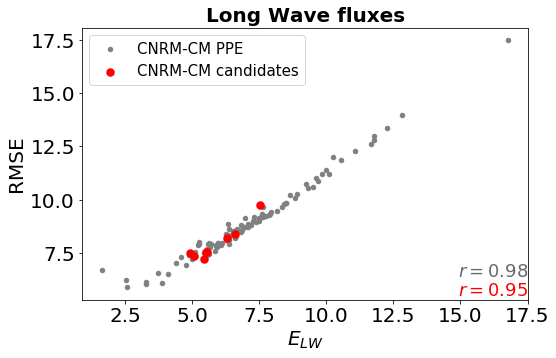

In [57]:
plt.figure(figsize=(8, 5))
    

ax = plt.gca()
#ax2 = ax.twinx()


df_fig.plot(kind='scatter', y='RMSE', x='E_tas', color = 'gray', alpha=1, ax=ax)
df_fig_select.plot(kind='scatter', y='RMSE', x='E_tas', color = 'red', linewidth=4, alpha=1, ax=ax)

#ax.axhline(0, color='k', alpha=0.5)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('$E_{LW}$', size = 20)
ax.set_ylabel('RMSE', size = 20)
ax.set_title('Long Wave fluxes', fontsize=20, 
             fontweight = 'bold')

plt.text(1,0.07,r'$r = 0.98$',horizontalalignment='right',color='dimgray',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)
plt.text(1,0.0,r'$r = 0.95$',horizontalalignment='right', color='red',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
#ax.plot((0.3, 1.75), (1, 2), linewidth=1.0, color='gray', alpha=0.2)

#plt.xlim([0.0, 2.0])
#plt.ylim([0.0, 2.0])

# Legend .................

legend = [ 'CNRM-CM PPE', 'CNRM-CM candidates']
#ax.get_legend().remove()
ax.legend(legend, fontsize=15) #bbox_to_anchor=(1.05, 1)
#fig.subplots_adjust(right=0.8)

# Grid .................
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Correl_RMSE_E_"+variable+".png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### [Back to the top](#top)